
# Machine Learning Project Proposal #

## Exploring Used Car Auction: *Prices and Predicting the Possible End Price*

### Simon Coessens, Rana Islek

### April 2024



### Necessary Libraries

In [1]:
!pip install numpy==1.23.5
!pip install pandas==1.5.2
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 20.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 1.5.2 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.5.2 which is incompatible.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import skew
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
pd.set_option('display.max_columns', None)
%matplotlib inline
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

### Import Data

In [5]:
dfcar = pd.read_csv('/content/drive/My Drive/ml-project/car_prices.csv', on_bad_lines='skip')
dfcar.head(2)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,"kia motors america, inc",20500,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,"kia motors america, inc",20800,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)


**Some Information About Each Feature:**

* Date : The year of production of the cars.

* Make : The brand of the car.

* Model : The edition of the car of a specific brand.

* Trim : The trim levels for a car are just different versions of the model.

* Body : The body style of a vehicle refers to the shape and model of a particular car make.

* Transmission : The mechanism that moves the power from the engine to the wheels.

* VIN : Vehichel identification number.

* State : The state in which the car is auctioned.

* Condition : The condition of the cars being at the time of auction.

* Odometer : The distance the car has travelled since manufactured.

* Color : Exterior color of the car.

* Interior : Interior color of the car.

* Seller : The seller of the car, car dealers.

* mmr : Manhiem market record, the market estimated price of the cars.

* sellingprice : The price a car was sold at auctions.

* saledate : The date on which the car has been sold.

### Data Cleansing

In [6]:
dfcar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558811 entries, 0 to 558810
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558811 non-null  int64  
 1   make          548510 non-null  object 
 2   model         548412 non-null  object 
 3   trim          548160 non-null  object 
 4   body          545616 non-null  object 
 5   transmission  493458 non-null  object 
 6   vin           558811 non-null  object 
 7   state         558811 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558717 non-null  float64
 10  color         558062 non-null  object 
 11  interior      558062 non-null  object 
 12  seller        558811 non-null  object 
 13  mmr           558811 non-null  int64  
 14  sellingprice  558811 non-null  int64  
 15  saledate      558811 non-null  object 
dtypes: float64(2), int64(3), object(11)
memory usage: 68.2+ MB


as that we can see, there are some columns that having null values so we should handle it in this stage before doing further analysis



In [7]:
# Numerical Column Describe
nums = dfcar.select_dtypes(exclude=['object'])
nums.describe(percentiles=(.25, .75, .90, .95, .98))

,year,condition,odometer,mmr,sellingprice
count,558811.000000,547017.000000,558717.000000,558811.000000,558811.000000
mean,2010.038696,3.424512,68323.195797,13769.324646,13611.262461
std,3.966812,0.949439,53397.752933,9679.874607,9749.656919
min,1982.000000,1.000000,1.000000,25.000000,1.000000
25%,2007.000000,2.700000,28374.000000,7100.000000,6900.000000
50%,2012.000000,3.600000,52256.000000,12250.000000,12100.000000
75%,2013.000000,4.200000,99112.000000,18300.000000,18200.000000
90%,2014.000000,4.600000,142760.400000,25500.000000,25500.000000
95%,2014.000000,4.800000,170059.000000,30600.000000,30600.000000
98%,2014.000000,5.000000,202596.680000,38500.000000,38500.000000


From the description of the data above, there are indications that there is data that does not make sense such as 1 and 999999 in odometer, 25 in mmr, and 1 in sellingprice.for the further process we would treat all not make sense values as outliers.



In [8]:
# non-Numerical Column Describe
cats = dfcar.select_dtypes(include=['object'])
cats.describe()

,make,model,trim,body,transmission,vin,state,color,interior,seller,saledate
count,548510,548412,548160,545616,493458,558811,558811,558062,558062,558811,558811
unique,96,973,1975,86,2,550296,38,20,17,14264,3745
top,Ford,Altima,Base,Sedan,automatic,wbanv13588cz57827,fl,black,black,nissan-infiniti lt,Tue Feb 10 2015 01:30:00 GMT-0800 (PST)
freq,93554,19349,55817,199437,475914,5,82945,110970,244325,19693,5334


as that we can see from the description table above, vin have so many unique values but it's make sense because it acts as identification number for each car but the one that should be considered is the difference between the count and unique values. so for further data processing we should check the possibilitieo for duplicate or Null values from vin column. the other columns looks make sense but we also need to do duplicate, Null, and uniformity check.



#### *Word Uniformity*

Because there is often a lack of uniformity in string, so it is necessary to uniforming the stirng before further processing



In [9]:
# Uppercase on each letter at the beginning of a word
dfcar['model'] = dfcar['model'].str.title()
dfcar['transmission'] = dfcar['transmission'].str.title()
dfcar['color'] = dfcar['color'].str.title()
dfcar['interior'] = dfcar['interior'].str.title()
dfcar['seller'] = dfcar['seller'].str.title()

# All Uppercase
dfcar['make'] = dfcar['make'].str.upper()
dfcar['body'] = dfcar['body'].str.upper()
dfcar['trim'] = dfcar['trim'].str.upper()
dfcar['state'] = dfcar['state'].str.upper()

#### *Duplicate Checking*

In [10]:
# 1. Entire Column
dfcar[dfcar.duplicated()]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate


In [11]:
#2. Specific Column
dfcar[dfcar.duplicated(['vin'], keep=False)]


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
21,2014,BMW,5 Series,528I,SEDAN,Automatic,wba5a5c51ed501631,CA,2.9,25969.0,Black,Black,Financial Services Remarketing (Lease),34200,30000,Tue Feb 03 2015 04:30:00 GMT-0800 (PST)
70,2014,AUDI,A8,L 3.0T QUATTRO,SEDAN,Automatic,waurgafd8en003111,CA,4.3,32918.0,Black,Black,Audi West Covina,62000,50000,Tue Dec 30 2014 12:30:00 GMT-0800 (PST)
382,2013,KIA,Soul,BASE,WAGON,Manual,kndjt2a54d7539154,CA,1.0,11699.0,Silver,Black,Kia Motors Finance,11400,6900,Tue Dec 16 2014 12:00:00 GMT-0800 (PST)
394,2013,NISSAN,Altima,2.5 S,COUPE,Automatic,1n4al2ep0dc231309,CA,1.0,33985.0,Black,Black,Remarketing By Ge/Manheim Southern California,13700,8000,Tue Dec 23 2014 13:00:00 GMT-0800 (PST)
432,2013,KIA,Rio,LX,SEDAN,Automatic,knadm4a3xd6113380,CA,2.0,45800.0,Black,Beige,Kia Motors Finance,8550,3850,Tue Jan 13 2015 13:00:00 GMT-0800 (PST)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558711,2009,JEEP,Wrangler,UNLIMITED RUBICON,SUV,Automatic,1j4ga69109l752295,NV,3.7,70423.0,White,Black,Millennium Cars,23100,17500,Fri Jun 19 2015 05:00:00 GMT-0700 (PDT)
558712,2008,FORD,F-250 Super Duty,LARIAT,CREW CAB,Automatic,1ftsw21rx8ea22277,NV,3.3,125628.0,Black,Beige,Bul Connections Llc,21000,18700,Fri Jun 19 2015 04:45:00 GMT-0700 (PDT)
558724,2007,SATURN,Aura,XE,SEDAN,Automatic,1g8zs57n17f246542,GA,2.9,82083.0,—,Beige,Carworks Inc,5450,5200,Tue Jun 23 2015 06:00:00 GMT-0700 (PDT)
558774,2012,KIA,Soul,BASE,WAGON,Manual,kndjt2a57c7424577,NV,2.8,53607.0,Silver,Black,Unique Autos,7825,8000,Fri Jul 03 2015 09:00:00 GMT-0700 (PDT)


It appears there is some duplicate data, so action will be taken to remove all duplicate values as each duplicate VIN has a different condition of the car, therefore it is best to remove it completely.



In [12]:
dfcar = dfcar.drop_duplicates(subset=['vin'])

In [13]:
dfcar = dfcar.drop_duplicates(subset=['vin'])

#### *Change Data Type:* *Change date type into datetime*


In [14]:
dfcar['saledate'] = dfcar['saledate'].str.split(' GMT', expand=True)[0]
dfcar['saledate'] = pd.to_datetime(dfcar['saledate'], format = '%a %b %d %Y %H:%M:%S')

In [15]:
dfcar.head(2)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,KIA,Sorento,LX,SUV,Automatic,5xyktca69fg566472,CA,5.0,16639.0,White,Black,"Kia Motors America, Inc",20500,21500,2014-12-16 12:30:00
1,2015,KIA,Sorento,LX,SUV,Automatic,5xyktca69fg561319,CA,5.0,9393.0,White,Beige,"Kia Motors America, Inc",20800,21500,2014-12-16 12:30:00


#### *Remove Null Values:*

In [16]:
# Null Value
dfcar.isnull().sum(axis = 0)

year                0
make            10104
model           10202
trim            10451
body            12987
transmission    64473
vin                 0
state               0
condition       11784
odometer           88
color             744
interior          744
seller              0
mmr                 0
sellingprice        0
saledate            0
dtype: int64

In [17]:
# Percentage of Null
dfcar.isnull().sum() / dfcar.shape[0] * 100.00

year             0.000000
make             1.836103
model            1.853911
trim             1.899160
body             2.360003
transmission    11.716058
vin              0.000000
state            0.000000
condition        2.141393
odometer         0.015991
color            0.135200
interior         0.135200
seller           0.000000
mmr              0.000000
sellingprice     0.000000
saledate         0.000000
dtype: float64

Because empty values are found, several treatments will be carried out using the method deemed most appropriate for each column



### A. make, condition, odometer column

For make column, because the rows that having Null values in that column also having Null values in model column so the only way to handle is to delete the rows, for condition and odometer because the values inside that columns are categorized as an unique values for each car so i decide to delete the rows.



In [18]:
# delete rows with Null values in 'make' column
dfcar = dfcar.dropna(subset=['make', 'condition', 'odometer'])

### B. Model Column

In [19]:
(dfcar[dfcar['model'].isnull()]).head(2)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
72,2014,BMW,NaN,750LI,SEDAN,Automatic,wbaye8c59ed134514,CA,4.3,12172.0,Black,Black,Financial Services Remarketing (Lease),67000,66000,2014-12-18 12:30:00
31262,2014,BMW,NaN,750I,SEDAN,Automatic,wbaya8c52ed825069,GA,4.4,4488.0,Silver,Black,Global Imports,67000,64200,2014-12-18 10:00:00


In [20]:
dfcar.model.isnull().value_counts()

False    528376
True         98
Name: model, dtype: int64

After doing some analysis, Null values are only found at the row with some specific trim, so we would replace the Null values by refering to the values with common trim


In [21]:
def category_model(x):
    if pd.isnull(x.model):
        if '2.0 TFSI PREMIUM QUATTRO' in str(x.trim):
            return 'A4'
        elif '750I' in str(x.trim):
            return '7 Series'
        elif '750LI' in str(x.trim):
             return '7 Series'
        elif '650I' in str(x.trim):
             return '6 Series'
        else:
            return str(x.model)
    else:
        return str(x.model)


dfcar['model'] = dfcar.apply(lambda x: category_model(x), axis=1)

In [22]:
dfcar.model.isnull().value_counts()

False    528474
Name: model, dtype: int64

### C. trim, body, transmission, color, and interior column

Each Null values in trim, body, transmission, color, and interior would be replaced by mode



In [23]:
# lazy grouping
groups = dfcar.groupby('model')

# where all the rows within a group is NaN
all_na = groups['trim'].transform(lambda x: x.isna().all())

# fill global mode
dfcar.loc[all_na, 'trim'] = dfcar['trim'].mode()[0]

# fill with local mode
mode_by_group = groups['trim'].transform(lambda x: x.mode()[0])
dfcar['trim'] = dfcar['trim'].fillna(mode_by_group)

In [24]:
mode_features = ['body','transmission','color','interior']

for var in mode_features:
    groups = dfcar.groupby('trim')
    all_na = groups[var].transform(lambda x: x.isna().all())
    dfcar.loc[all_na, var] = dfcar[var].mode()[0]
    mode_by_group = groups[var].transform(lambda x: x.mode()[0])
    dfcar[var] = dfcar[var].fillna(mode_by_group)

In [25]:
# Checking Null
dfcar.isnull().sum(axis = 0)

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
mmr             0
sellingprice    0
saledate        0
dtype: int64

### 3.5. Handling Outlier
At this stage, outliers that were previously considered unreasonable will be removed


year
skewness: -1.2324719146297944

condition
skewness: -0.36296384797117937

odometer
skewness: 1.9294463157433306

mmr
skewness: 2.024040856855998

sellingprice
skewness: 1.977485867618144


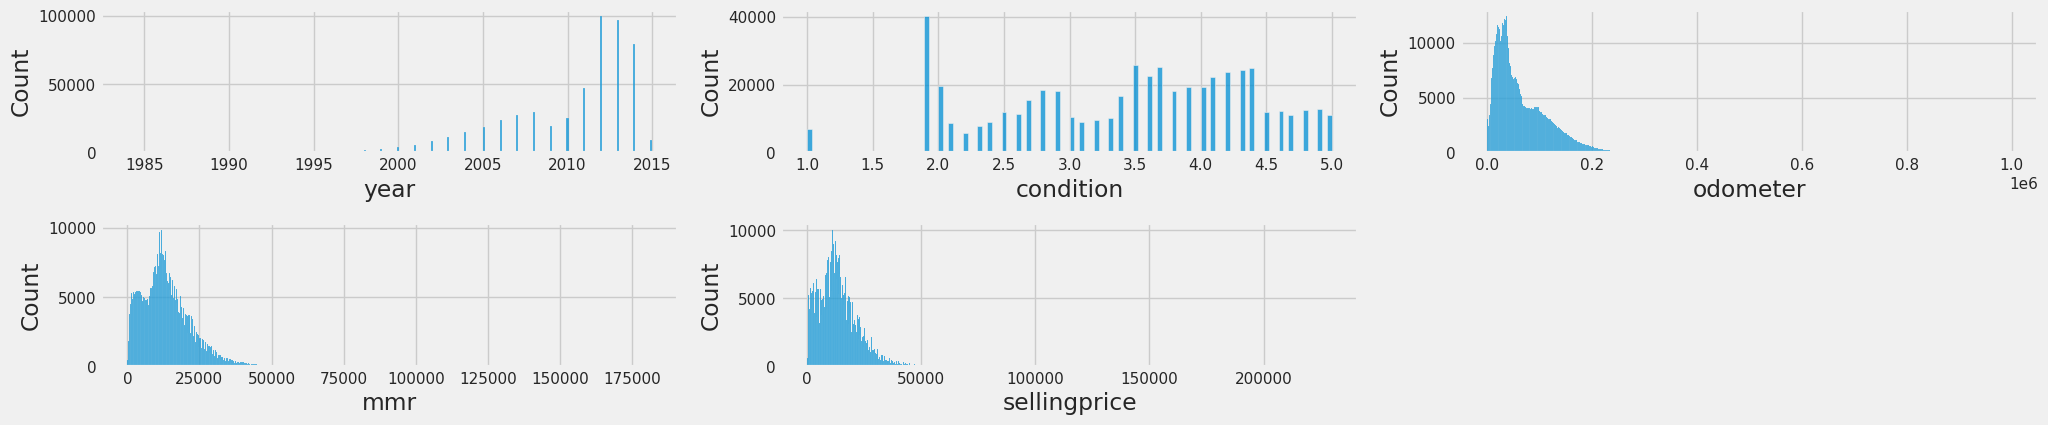

In [26]:
nums = dfcar.select_dtypes(exclude=['object', 'datetime'])

for i, column in enumerate(nums.columns, 1):
    print(f'\n{column}')
    print(f'skewness: {skew(nums[column])}')

    plt.subplot(4, 3, i)
    sns.histplot(nums[column]) #or displot
    plt.tight_layout()

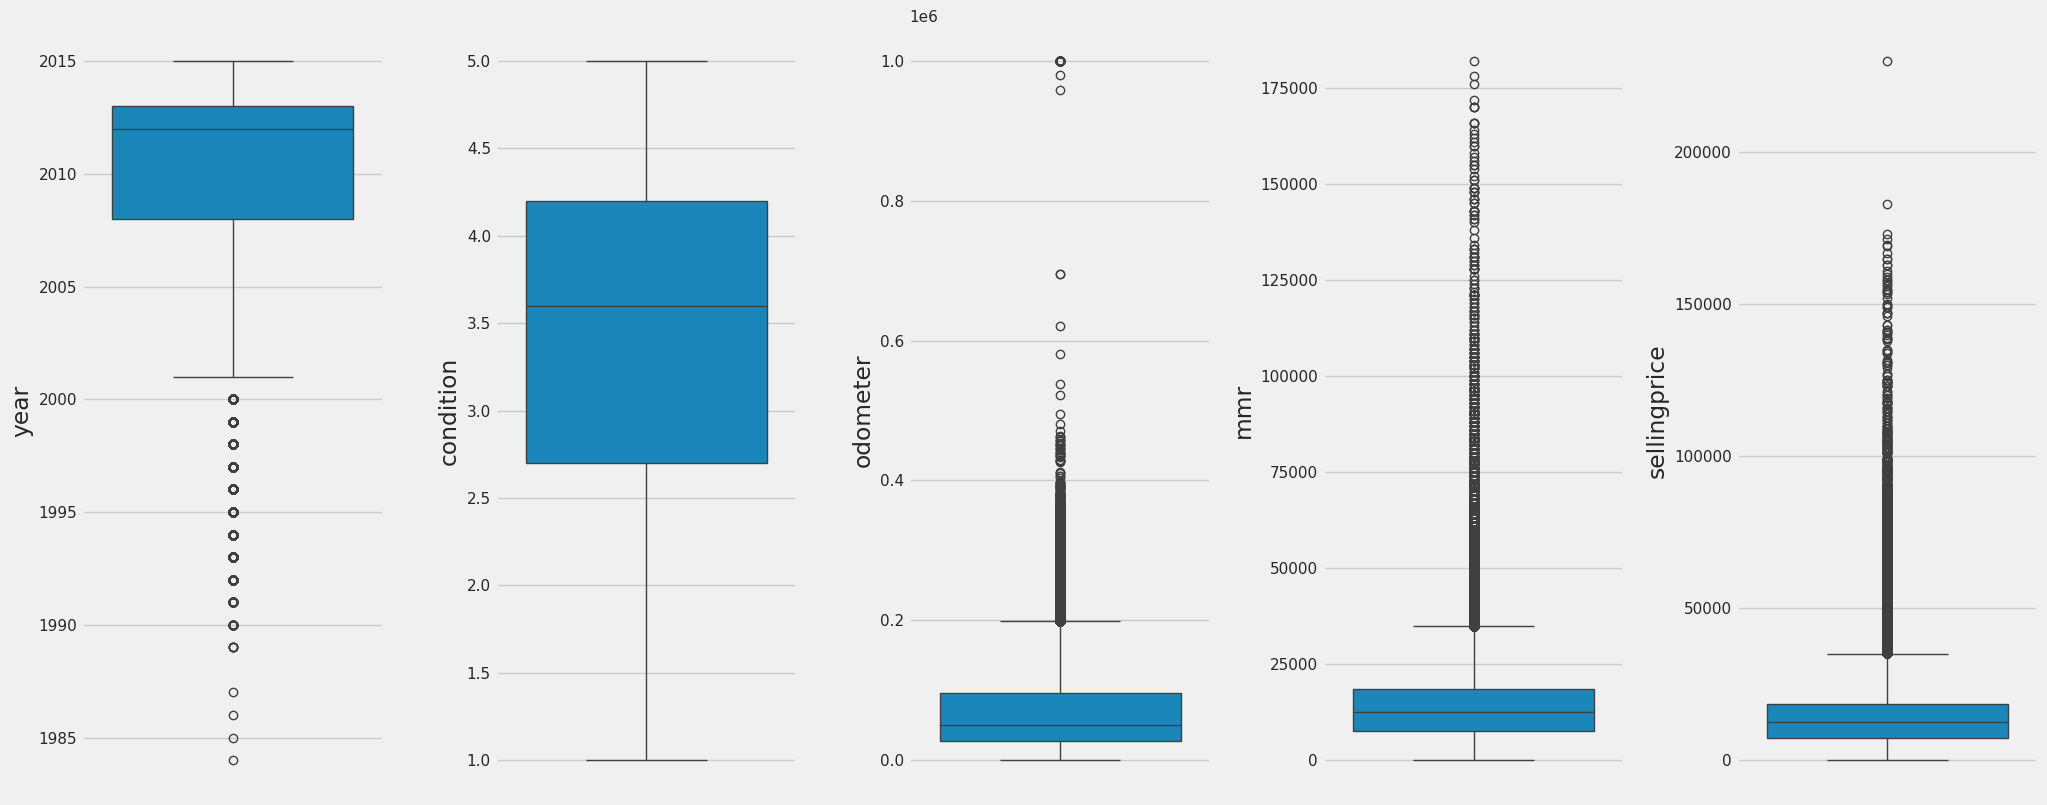

In [27]:
for i, column in enumerate(nums.columns, 1):
    plt.subplot(1, len(nums.columns), i)
    sns.boxplot(y=nums[column])
    plt.tight_layout()

In [28]:
def outlier_del(df, column, mode):
    q1 = df.iloc[:,column].quantile(0.25)
    q3 = df.iloc[:,column].quantile(0.75)
    iqr = q3-q1
    lower_tail = q1 - (1.5 * iqr)
    upper_tail = q3 + (1.5 * iqr)
    nama_kolom = df.columns[column]
    jumlah_outliers = df[(df.iloc[:,column] <= lower_tail)|(df.iloc[:,column] >= upper_tail)].iloc[:,column].count()
    total_row = df.iloc[:,column].count()
    persentase_outliers = round(((jumlah_outliers/total_row)*100),2)
    if mode == 'summary': # Summary of the outliers
        return print('Total Outliers from ', nama_kolom, ' column :', jumlah_outliers, ' and the percentage of the outliers:', persentase_outliers, '%')
    elif mode == 'df': # Delete Outliers
        return df[(df.iloc[:,column] >= lower_tail)&(df.iloc[:,column] <= upper_tail)]
    else :
        return print('Check the input mode')

In [29]:
dfcar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 528474 entries, 0 to 558810
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   year          528474 non-null  int64         
 1   make          528474 non-null  object        
 2   model         528474 non-null  object        
 3   trim          528474 non-null  object        
 4   body          528474 non-null  object        
 5   transmission  528474 non-null  object        
 6   vin           528474 non-null  object        
 7   state         528474 non-null  object        
 8   condition     528474 non-null  float64       
 9   odometer      528474 non-null  float64       
 10  color         528474 non-null  object        
 11  interior      528474 non-null  object        
 12  seller        528474 non-null  object        
 13  mmr           528474 non-null  int64         
 14  sellingprice  528474 non-null  int64         
 15  saledate      528

In [30]:
# Outliers Checking for each Column
column = [9, 13, 14]

for i in range(0, len(column)):
    outlier_del(dfcar, column[i], 'summary')

Total Outliers from  odometer  column : 10782  and the percentage of the outliers: 2.04 %
Total Outliers from  mmr  column : 15948  and the percentage of the outliers: 3.02 %
Total Outliers from  sellingprice  column : 15731  and the percentage of the outliers: 2.98 %


In [31]:
# Deleting Outliers
for i in range(0, len(column)):
    dfcar = dfcar[dfcar.index.isin(outlier_del(dfcar, column[i], 'df').reset_index()['index'])]

In [32]:
dfcar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497511 entries, 0 to 558810
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   year          497511 non-null  int64         
 1   make          497511 non-null  object        
 2   model         497511 non-null  object        
 3   trim          497511 non-null  object        
 4   body          497511 non-null  object        
 5   transmission  497511 non-null  object        
 6   vin           497511 non-null  object        
 7   state         497511 non-null  object        
 8   condition     497511 non-null  float64       
 9   odometer      497511 non-null  float64       
 10  color         497511 non-null  object        
 11  interior      497511 non-null  object        
 12  seller        497511 non-null  object        
 13  mmr           497511 non-null  int64         
 14  sellingprice  497511 non-null  int64         
 15  saledate      497

In [33]:
df_clean = dfcar.copy()

## 4. FEATURE EXTRACTION

### 4.1. Body Simplified

In [34]:
print(df_clean['body'].unique())

['SUV' 'SEDAN' 'CONVERTIBLE' 'COUPE' 'WAGON' 'HATCHBACK' 'CREW CAB'
 'G COUPE' 'G SEDAN' 'ELANTRA COUPE' 'GENESIS COUPE' 'MINIVAN' 'VAN'
 'DOUBLE CAB' 'CREWMAX CAB' 'ACCESS CAB' 'KING CAB' 'SUPERCREW'
 'CTS COUPE' 'EXTENDED CAB' 'E-SERIES VAN' 'SUPERCAB' 'REGULAR CAB'
 'G CONVERTIBLE' 'KOUP' 'QUAD CAB' 'G37 CONVERTIBLE' 'CLUB CAB' 'XTRACAB'
 'CTS WAGON' 'CTS-V COUPE' 'G37 COUPE' 'MEGA CAB' 'CAB PLUS 4' 'Q60 COUPE'
 'Q60 CONVERTIBLE' 'BEETLE CONVERTIBLE' 'TSX SPORT WAGON'
 'PROMASTER CARGO VAN' 'CAB PLUS' 'RAM VAN' 'TRANSIT VAN' 'REGULAR-CAB']


After looking at the unique value in thebody column, information is obtained that there are several values that are similar, therefore simplification will be carried out in the body column



In [35]:
def category_body(x):
    if 'SUV' in x:
        return 'SUV'
    elif 'SEDAN' in x:
        return 'Sedan'
    elif 'CONVERTIBLE' in x:
         return 'Convertible'
    elif 'COUPE' in x:
        return 'Coupe'
    elif 'KOUP' in x:
        return 'Coupe'
    elif 'WAGON' in x:
        return 'Wagon'
    elif 'HATCHBACK' in x:
        return 'Hatchback'
    elif 'CAB' in x:
        return 'CAB'
    elif 'SUPERCREW' in x:
        return 'CAB'
    elif 'VAN' in x:
        return 'VAN'
    else:
        return "other"

df_clean['body_simple'] = df_clean.apply(lambda x: category_body(x.body), axis=1)


### 4.2. Brand

In [36]:
print(df_clean['make'].unique())

['KIA' 'BMW' 'VOLVO' 'NISSAN' 'CHEVROLET' 'AUDI' 'FORD' 'BUICK' 'ACURA'
 'HYUNDAI' 'CADILLAC' 'INFINITI' 'LEXUS' 'MITSUBISHI' 'MERCEDES-BENZ'
 'JEEP' 'MAZDA' 'MINI' 'LINCOLN' 'JAGUAR' 'VOLKSWAGEN' 'TOYOTA' 'SUBARU'
 'SCION' 'DODGE' 'FIAT' 'CHRYSLER' 'HONDA' 'GMC' 'RAM' 'SMART'
 'LAND ROVER' 'PONTIAC' 'SATURN' 'MERCURY' 'HUMMER' 'LANDROVER' 'MERCEDES'
 'PORSCHE' 'SAAB' 'SUZUKI' 'OLDSMOBILE' 'GEO' 'MASERATI' 'ISUZU' 'FORD TK'
 'PLYMOUTH' 'FORD TRUCK' 'DOT' 'VW' 'GMC TRUCK' 'MERCEDES-B' 'DAEWOO']


After looking at the unique value in the
make column, it is known that there are several values that are the same brand but written differently, therefore uniformity will be carried out.



In [37]:
def body(x):
    if 'CHEV TRUCK' in str(x):
        return 'CHEVROLET'
    elif 'DODGE' in str(x):
        return 'DODGE'
    elif 'FORD' in str(x):
         return 'FORD'
    elif 'GMC TRUCK' in str(x):
         return 'GMC'
    elif 'HYUNDAI' in str(x):
         return 'HYUNDAI'
    elif 'LANDROVER' in str(x):
         return 'LAND ROVER'
    elif 'MERCEDES' in str(x):
         return 'MERCEDES-BENZ'
    elif 'MERCEDES-B' in str(x):
         return 'MERCEDES-BENZ'
    elif 'VW' in str(x):
         return 'VOLKSWAGEN'
    else:
        return str(x)


df_clean['brand'] = df_clean.apply(lambda x: body(x.make), axis=1)

### 4.3. Made in
Each brand is grouped based on the company's country of origin

In [38]:
China = ['SMART']
Germany = ['AUDI', 'BMW', 'MERCEDES-BENZ', 'PORSCHE', 'VOLKSWAGEN']
Italy = ['FERRARI', 'FIAT', 'LAMBORGHINI', 'MASERATI']
Japan = ['ACURA', 'HONDA', 'INFINITI', 'ISUZU', 'LEXUS', 'MAZDA', 'MITSUBISHI', 'NISSAN', 'SUBARU', 'SUZUKI', 'TOYOTA']
South_Korea = ['DAEWOO', 'HYUNDAI', 'KIA']
Sweden = ['SAAB', 'VOLVO']
US = ['AIRSTREAM', 'BUICK', 'CADILLAC', 'CHEVROLET', 'CHRYSLER', 'DODGE', 'FISKER', 'FORD', 'GEO', 'GMC', 'HUMMER', 'JEEP', 'LINCOLN', 'MERCURY', 'OLDSMOBILE', 'PONTIAC', 'PLYMOUTH', 'RAM', 'SATURN', 'SCION', 'DOT' ]
UK = ['ASTON MARTIN', 'BENTLEY', 'JAGUAR', 'LAND ROVER', 'LOTUS', 'MINI', 'ROLLS-ROYCE', 'TESLA']

def made_in(x):
    if str(x) in China:
        return 'CHN'
    elif str(x) in Germany:
        return 'DEU'
    elif str(x) in Italy:
        return 'ITA'
    elif str(x) in Japan:
        return 'JPN'
    elif str(x) in South_Korea:
        return 'KOR'
    elif str(x) in Sweden:
        return 'SWE'
    elif str(x) in US:
        return 'USA'
    elif str(x) in UK:
        return 'GBR'
    else:
        return "other"

df_clean['made_in'] = df_clean.apply(lambda x: made_in(x.brand), axis=1)

### 4.4. Time Extraction
From the saledate column the information will be extracted into several new pieces of information

### A. Is Weekend

In [39]:
## 'day_of_week' Column
df_clean['day_of_week'] = df_clean['saledate'].dt.day_name().str[:3]

## 'is_weekend' Column
weekday = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
weekend = ['Sat', 'Sun']

def is_weekend(x):
    if str(x) in weekday:
        return 0
    elif str(x) in weekend:
        return 1
    else:
        return "other"

df_clean['is_weekend'] = df_clean.apply(lambda x: is_weekend(x.day_of_week), axis=1)

### B. Hour Only

In [40]:
## 'hour_only' Column
df_clean['hour_only'] = df_clean['saledate'].dt.hour

### C. Month and Year

In [41]:
## 'month_year' Column
df_clean['month_year'] = df_clean.saledate.dt.strftime('%b-%y')

### D. Sale Date

In [42]:
## 'sale_date' Column
df_clean['sale_date'] = df_clean['saledate'].dt.date
df_clean['sale_date'] = pd.to_datetime(df_clean['sale_date'], format = '%Y-%m-%d')

### 4.5. Car Age
The car_age column is created based on the difference between the year of sale and the year of production of the car

In [43]:
## 'sale_year' column
df_clean['sale_year'] = df_clean['saledate'].dt.year
df_clean['car_age'] = df_clean['sale_year'] - df_clean['year']

In [44]:
# Check for unlogic rows
# Checking if there is unlogic rows
df_clean[df_clean['car_age'] < 0]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate,body_simple,brand,made_in,day_of_week,is_weekend,hour_only,month_year,sale_date,sale_year,car_age
0,2015,KIA,Sorento,LX,SUV,Automatic,5xyktca69fg566472,CA,5.0,16639.0,White,Black,"Kia Motors America, Inc",20500,21500,2014-12-16 12:30:00,SUV,KIA,KOR,Tue,0,12,Dec-14,2014-12-16,2014,-1
1,2015,KIA,Sorento,LX,SUV,Automatic,5xyktca69fg561319,CA,5.0,9393.0,White,Beige,"Kia Motors America, Inc",20800,21500,2014-12-16 12:30:00,SUV,KIA,KOR,Tue,0,12,Dec-14,2014-12-16,2014,-1
5,2015,NISSAN,Altima,2.5 S,SEDAN,Automatic,1n4al3ap1fn326013,CA,1.0,5554.0,Gray,Black,Enterprise Vehicle Exchange / Tra / Rental / T...,15350,10900,2014-12-30 12:00:00,Sedan,NISSAN,JPN,Tue,0,12,Dec-14,2014-12-30,2014,-1
11,2015,KIA,Optima,LX,SEDAN,Automatic,5xxgm4a73fg353538,CA,4.8,2034.0,Red,Tan,Kia Motors Finance,15150,17700,2014-12-16 12:00:00,Sedan,KIA,KOR,Tue,0,12,Dec-14,2014-12-16,2014,-1
13,2015,KIA,Sorento,LX,SUV,Automatic,5xyktca66fg561407,CA,5.0,14634.0,Silver,Black,"Kia Motors America, Inc",20600,21500,2014-12-16 12:30:00,SUV,KIA,KOR,Tue,0,12,Dec-14,2014-12-16,2014,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68986,2015,HYUNDAI,Elantra,SE,SEDAN,Automatic,5npdh4ae9fh574412,IN,4.0,7661.0,Gray,Beige,Enterprise Vehicle Exchange / Tra / Rental / T...,13850,9200,2014-12-31 12:59:00,Sedan,HYUNDAI,KOR,Wed,0,12,Dec-14,2014-12-31,2014,-1
69268,2015,NISSAN,Altima,2.5 S,SEDAN,Automatic,1n4al3ap5fn318335,PA,1.0,9399.0,Red,Black,Enterprise Veh Exchange/Rental,14950,3600,2014-12-30 10:45:00,Sedan,NISSAN,JPN,Tue,0,10,Dec-14,2014-12-30,2014,-1
70515,2015,CHRYSLER,200,LIMITED,SEDAN,Automatic,1c3cccab8fn578112,IN,2.0,73.0,Gray,Tan,Enterprise Vehicle Exchange / Tra / Rental / T...,16050,6600,2014-12-31 12:59:00,Sedan,CHRYSLER,USA,Wed,0,12,Dec-14,2014-12-31,2014,-1
73093,2015,FORD,Fusion,SE,SEDAN,Automatic,3fa6p0h78fr170788,TX,5.0,3427.0,White,Black,Rlb Investments,13700,16300,2014-12-31 10:20:00,Sedan,FORD,USA,Wed,0,10,Dec-14,2014-12-31,2014,-1


Because we found unlogic values in car_age so we decide to delete the rows with minus car_age values

In [45]:
df_clean = df_clean[df_clean['car_age'] >= 0]

### 4.6. Is Sold Below MMR
To find out whether the auction price matches the market price based on MMR, a column is_sold_below_mmr is created.

In [46]:
# 'is_sold_below_mmr' column (1=Yes, 0=No)
df_clean['is_sold_below_mmr'] = df_clean.apply(lambda x: 1 if x.sellingprice < x.mmr else 0, axis=1)

### 4.7. Longitude and latitude
To get the longitude and latitude coordinates, a new dataset will be imported

In [47]:
state_coordinate = pd.read_csv('/content/drive/My Drive/ml-project/statelatlong.csv')
state_coordinate.State.unique()

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'], dtype=object)

After the import is carried out, the list of states in the main dataset is checked



In [48]:
df_clean.state.sort_values().unique()

array(['AB', 'AL', 'AZ', 'CA', 'CO', 'FL', 'GA', 'HI', 'IL', 'IN', 'LA',
       'MA', 'MD', 'MI', 'MN', 'MO', 'MS', 'NC', 'NE', 'NJ', 'NM', 'NS',
       'NV', 'NY', 'OH', 'OK', 'ON', 'OR', 'PA', 'PR', 'QC', 'SC', 'TN',
       'TX', 'UT', 'VA', 'WA', 'WI'], dtype=object)

Because there are states data that are not available in the longitude and latitude datasets, manual input will be carried out



In [49]:
state_coor = pd.DataFrame({'State': ['AB', 'ON', 'PR', 'QC'] ,
                           'Latitude': [53.9333, 51.2538, 18.2208, 46.8131],
                           'Longitude': [-116.5765, -85.3232, -66.5901, -71.2075],
                           'City':['Alberta', 'Ontario', 'Puerto Rico', 'Quebec']})

In [50]:
#state_coordinate = state_coordinate.append(state_coor, ignore_index=True)
#state_coordinate.rename({'State':'state', 'Latitude':'latitude', 'Longitude':'longitude'}, axis=1, inplace=True)

state_coordinate = pd.concat([state_coordinate, state_coor], ignore_index=True)
state_coordinate.rename(columns={'State': 'state', 'Latitude': 'latitude', 'Longitude': 'longitude'}, inplace=True)

Next, the data is combined into the main dataset

In [51]:
# Merge
df_clean = df_clean.merge(state_coordinate[['state', 'latitude', 'longitude']], how='left', on='state')
df_clean.sample(2)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate,body_simple,brand,made_in,day_of_week,is_weekend,hour_only,month_year,sale_date,sale_year,car_age,is_sold_below_mmr,latitude,longitude
91828,2013,CHRYSLER,200,TOURING,SEDAN,Automatic,1c3ccbbg5dn678556,MD,2.9,38045.0,Gray,Black,"All Car Leasing,Inc",10900,10700,2015-02-03 01:30:00,Sedan,CHRYSLER,USA,Tue,0,1,Feb-15,2015-02-03,2015,2,1,38.806352,-77.268416
359304,2012,KIA,Optima,LX,SEDAN,Automatic,5xxgm4a7xcg026811,PA,3.9,35423.0,White,Beige,Kia Motors Finance,11750,11200,2015-05-22 02:00:00,Sedan,KIA,KOR,Fri,0,2,May-15,2015-05-22,2015,3,1,40.994593,-77.604698


In [52]:
df_clean.head(2)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate,body_simple,brand,made_in,day_of_week,is_weekend,hour_only,month_year,sale_date,sale_year,car_age,is_sold_below_mmr,latitude,longitude
0,2014,BMW,3 Series,328I SULEV,SEDAN,Automatic,wba3c1c51ek116351,CA,4.5,1331.0,Gray,Black,Financial Services Remarketing (Lease),31900,30000,2015-01-15 04:30:00,Sedan,BMW,DEU,Thu,0,4,Jan-15,2015-01-15,2015,1,1,37.271875,-119.270415
1,2015,VOLVO,S60,T5,SEDAN,Automatic,yv1612tb4f1310987,CA,4.1,14282.0,White,Black,Volvo Na Rep/World Omni,27500,27750,2015-01-29 04:30:00,Sedan,VOLVO,SWE,Thu,0,4,Jan-15,2015-01-29,2015,0,0,37.271875,-119.270415


In [53]:
df_clean = df_clean.drop(['make', 'body', 'saledate'], axis=1)
# New column order
new_order = ['vin', 'year', 'brand', 'body_simple', 'model', 'trim',	'made_in', 'transmission',	'condition',	'color',	'interior', 'car_age', 	'odometer', 'state', 'seller', 'sellingprice', 'mmr', 'is_sold_below_mmr', 'day_of_week',	'is_weekend',	'hour_only',	'month_year',	'sale_date',	'sale_year', 'latitude',	'longitude']

# Reorder DataFrame
df_clean = df_clean[new_order]
df_clean.head(2)

,vin,year,brand,body_simple,model,trim,made_in,transmission,condition,color,interior,car_age,odometer,state,seller,sellingprice,mmr,is_sold_below_mmr,day_of_week,is_weekend,hour_only,month_year,sale_date,sale_year,latitude,longitude
0,wba3c1c51ek116351,2014,BMW,Sedan,3 Series,328I SULEV,DEU,Automatic,4.5,Gray,Black,1,1331.0,CA,Financial Services Remarketing (Lease),30000,31900,1,Thu,0,4,Jan-15,2015-01-15,2015,37.271875,-119.270415
1,yv1612tb4f1310987,2015,VOLVO,Sedan,S60,T5,SWE,Automatic,4.1,White,Black,0,14282.0,CA,Volvo Na Rep/World Omni,27750,27500,0,Thu,0,4,Jan-15,2015-01-29,2015,37.271875,-119.270415


## 5. INSIGHT AND VISUALIZATION
### 5.1. Sale Percentage Based on MMR

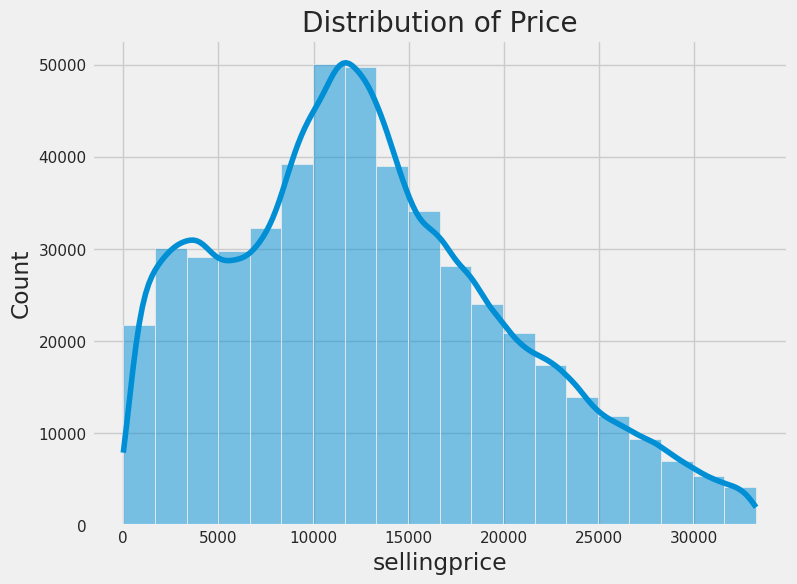

In [54]:
# Price Analysis
plt.figure(figsize=(8, 6))
sns.histplot(data=df_clean['sellingprice'], bins=20, kde=True)
plt.title('Distribution of Price')
plt.show()

### A. Total Transaction

In [55]:
transaction = df_clean.groupby('is_sold_below_mmr').agg({'vin':'count'}).rename({'vin':'total_transaction'}, axis=1)
transaction['percentage'] = round(((transaction/transaction.sum())*100), 2)
transaction

,total_transaction,percentage
is_sold_below_mmr,,
0,240769,48.41
1,256626,51.59


In [56]:
transaction.reset_index(inplace=True)
persentase_bawah_mmr = transaction[transaction['is_sold_below_mmr']==1].percentage
print(f'\nSale Percentage below MMR: {persentase_bawah_mmr[1]}%\n')


Sale Percentage below MMR: 51.59%



### B. Car Production Year

In [57]:
year_mmr = df_clean.groupby(['year', 'is_sold_below_mmr']).agg({'vin' : 'count'}).rename({'vin' : 'total_sold'}, axis=1)
year_mmr['percentage'] = round((year_mmr/(year_mmr.groupby(level=0).sum())*100), 2)
year_mmr.reset_index(inplace=True)
year_mmr= year_mmr[year_mmr['is_sold_below_mmr'] == 1]

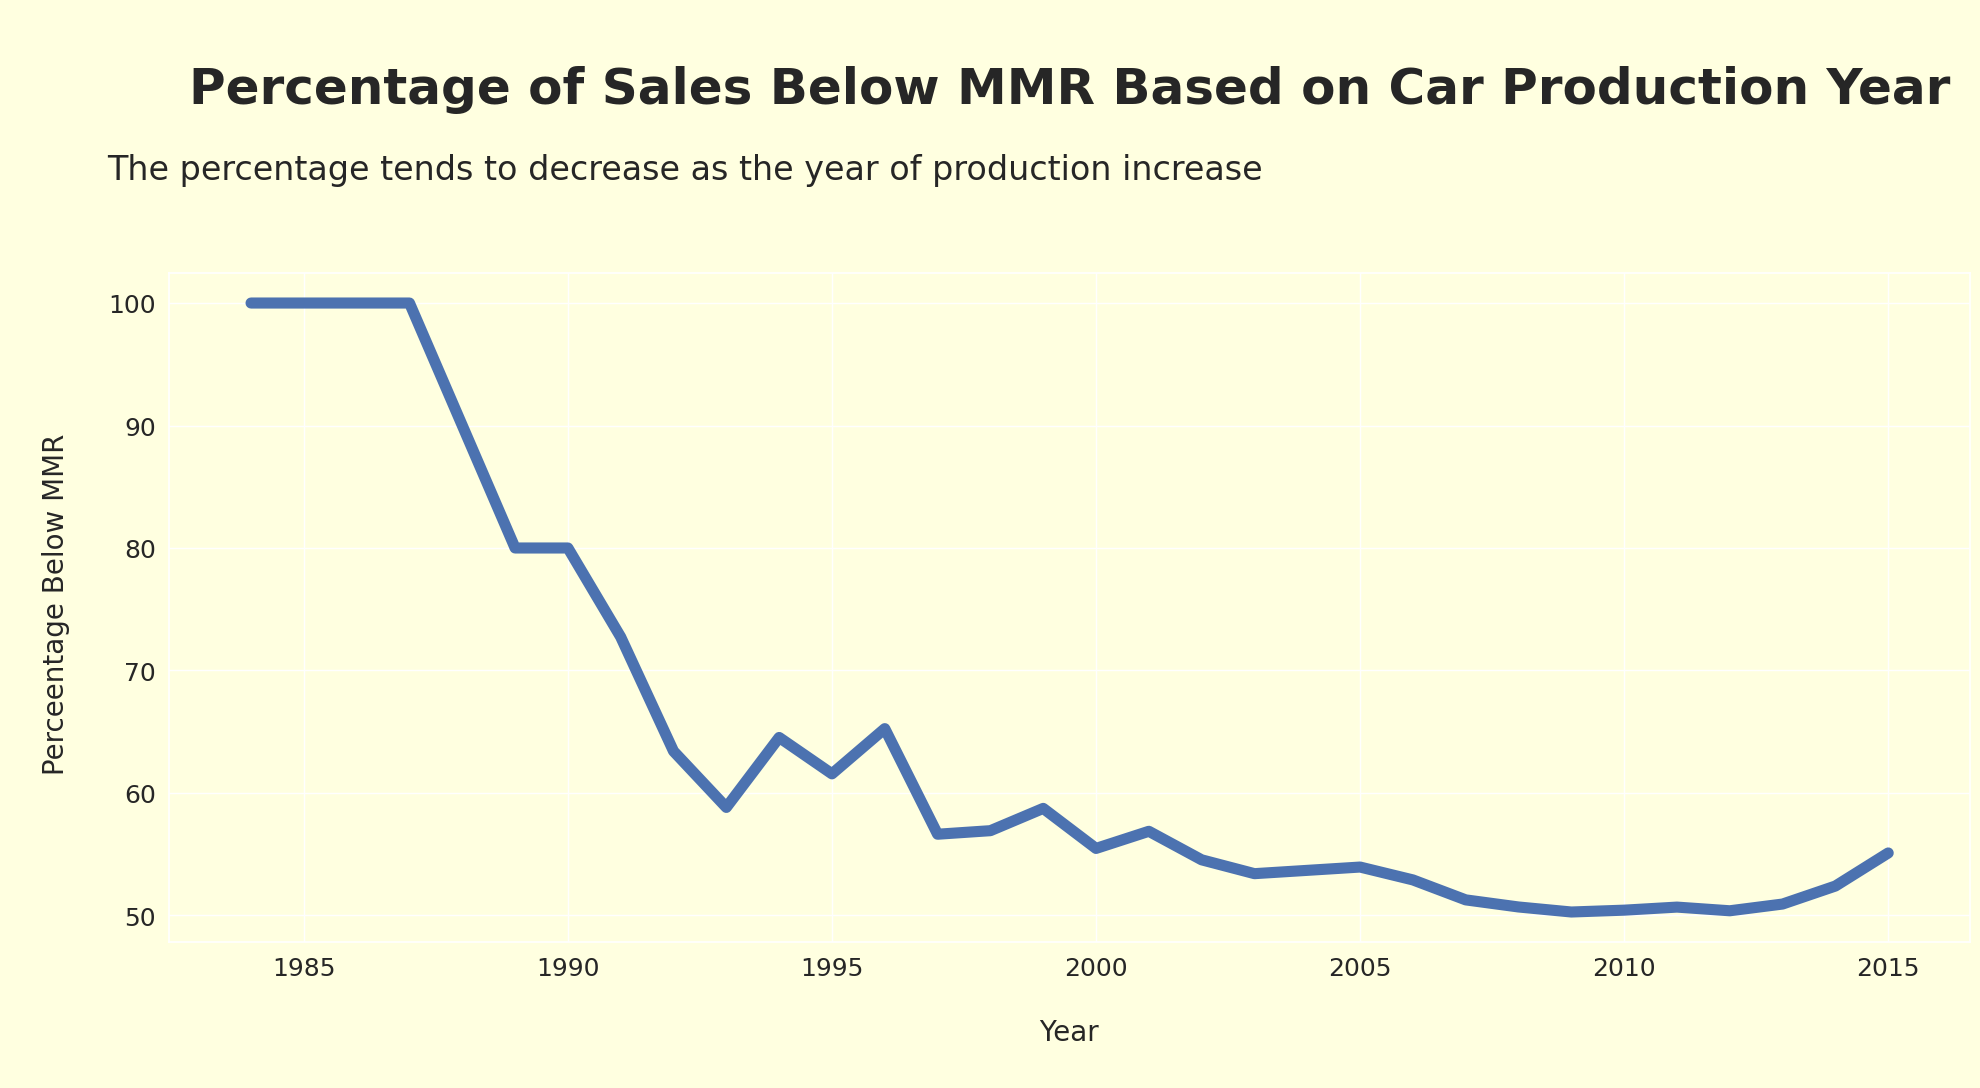

In [58]:
# set background color -- add for odometer
sns.set(rc={'axes.facecolor':'Lightyellow', 'figure.facecolor':'Lightyellow'})

sns.lineplot(year_mmr, x='year', y='percentage', linewidth = 8)
plt.title('\nPercentage of Sales Below MMR Based on Car Production Year', fontsize=36, fontweight='bold', y=1.15, pad=50)
plt.suptitle("The percentage tends to decrease as the year of production increase", size=24, x=.05, y=1.025, ha='left')
plt.xlabel('\n Year \n', fontsize=20)
plt.ylabel('\n Perceentage Below MMR\n', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

### 5.2. Total Transaction
#### A Based on Time

### I. Monthly

In [59]:
# Grouping based on 'month_year' colunm
monthly_sale_summary = df_clean.groupby(['month_year']).agg({'vin' : 'count', 'mmr' : ['sum', 'mean'], 'sellingprice' : ['sum', 'mean'] }).reset_index()
monthly_sale_summary.columns = ['date', 'total_transaction', 'mmr_sum', 'mmr_avg', 'selling_sum', 'selling_avg']

# manual sorting
custom_dict = {'Jan-14':0, 'Feb-14':1, 'Dec-14':2, 'Jan-15':3, 'Feb-15':4, 'Mar-15':5, 'Apr-15':6, 'May-15':7, 'Jun-15':8, 'Jul-15':9}
monthly_sale_summary = monthly_sale_summary.sort_values(by=['date'], key=lambda x: x.map(custom_dict))

In [60]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=monthly_sale_summary.date,
    y=monthly_sale_summary.total_transaction,
    name='MMR'
))
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.25, y=1.3,
                              xanchor='left', yanchor='bottom',
                              text='<b> Monthly Total Transaction <b>',
                              font=dict(family='Arial',
                                        size=30),
                              showarrow=False))

annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.15,
                              xanchor='left', yanchor='bottom',
                              text='The graph shows an unsstable transaction history, and because the data is resoult of scrapping from various <br> resource, the monthly transaction history data created cannot be used as a benchmark.',
                              font=dict(family='Arial',
                                        size=16),
                              showarrow=False))
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    margin=dict(
        l=80,
        r=80,
        b=50,
        t=150,
        pad=10
    ),
    paper_bgcolor="LightYellow",
    plot_bgcolor="rgb(255, 249, 204)",
    annotations=annotations
)

# Set axis title
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Total Transaction")

fig.show()

### II. Daily

In [61]:
week_hour = df_clean.pivot_table(index='day_of_week',columns='hour_only',values='vin',aggfunc='count')
week_hour = week_hour.reindex(index=['Mon','Tue', 'Wed','Thu', 'Fri', 'Sat', 'Sun'])
week_hour = week_hour.fillna(0)

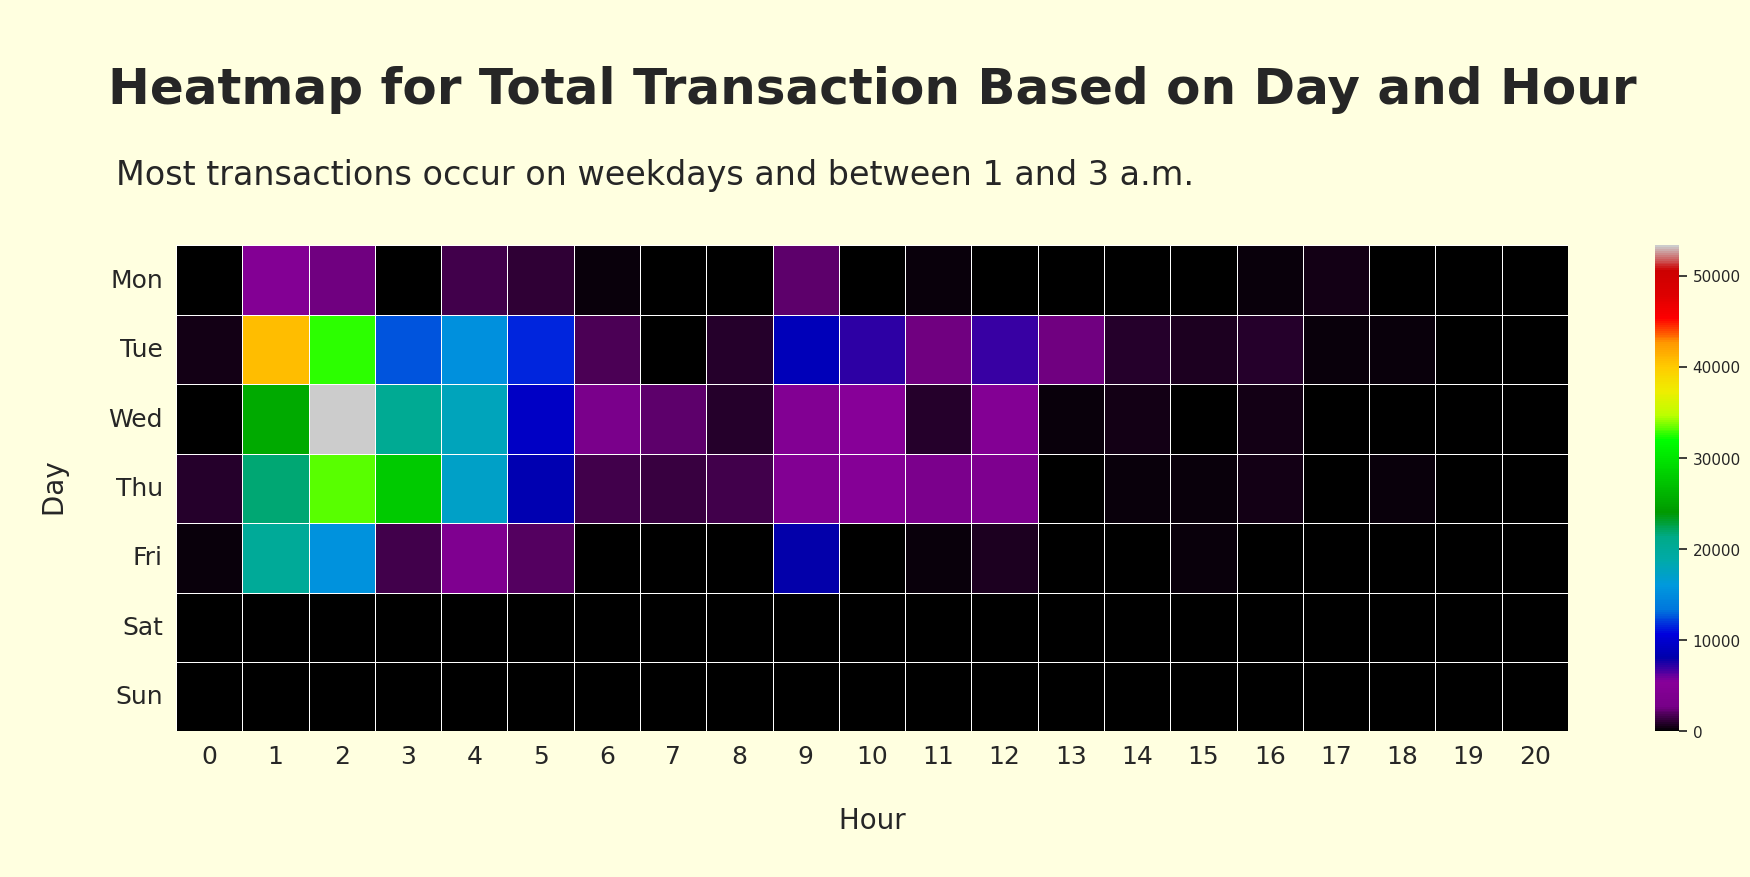

In [62]:
f, ax = plt.subplots(figsize=(20, 6))

# set background color
sns.set(rc={'axes.facecolor':'Lightyellow', 'figure.facecolor':'Lightyellow'})

sns.heatmap(week_hour, cmap='nipy_spectral', annot=False, fmt="2f", linewidths=.5, ax=ax)
plt.title('\nHeatmap for Total Transaction Based on Day and Hour', fontsize=36, fontweight='bold', y=1.15, pad=50)
plt.suptitle("Most transactions occur on weekdays and between 1 and 3 a.m.", size=24, x=.05, y=1.025, ha='left')
plt.xlabel('\n Hour \n', fontsize=20)
plt.ylabel('\n Day \n', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yticks(rotation=0)
plt.show()

### B. Based on Car Age

In [63]:
transaction_year = df_clean.groupby(['car_age'], as_index=False).vin.count().rename({'vin':'count'}, axis=1)

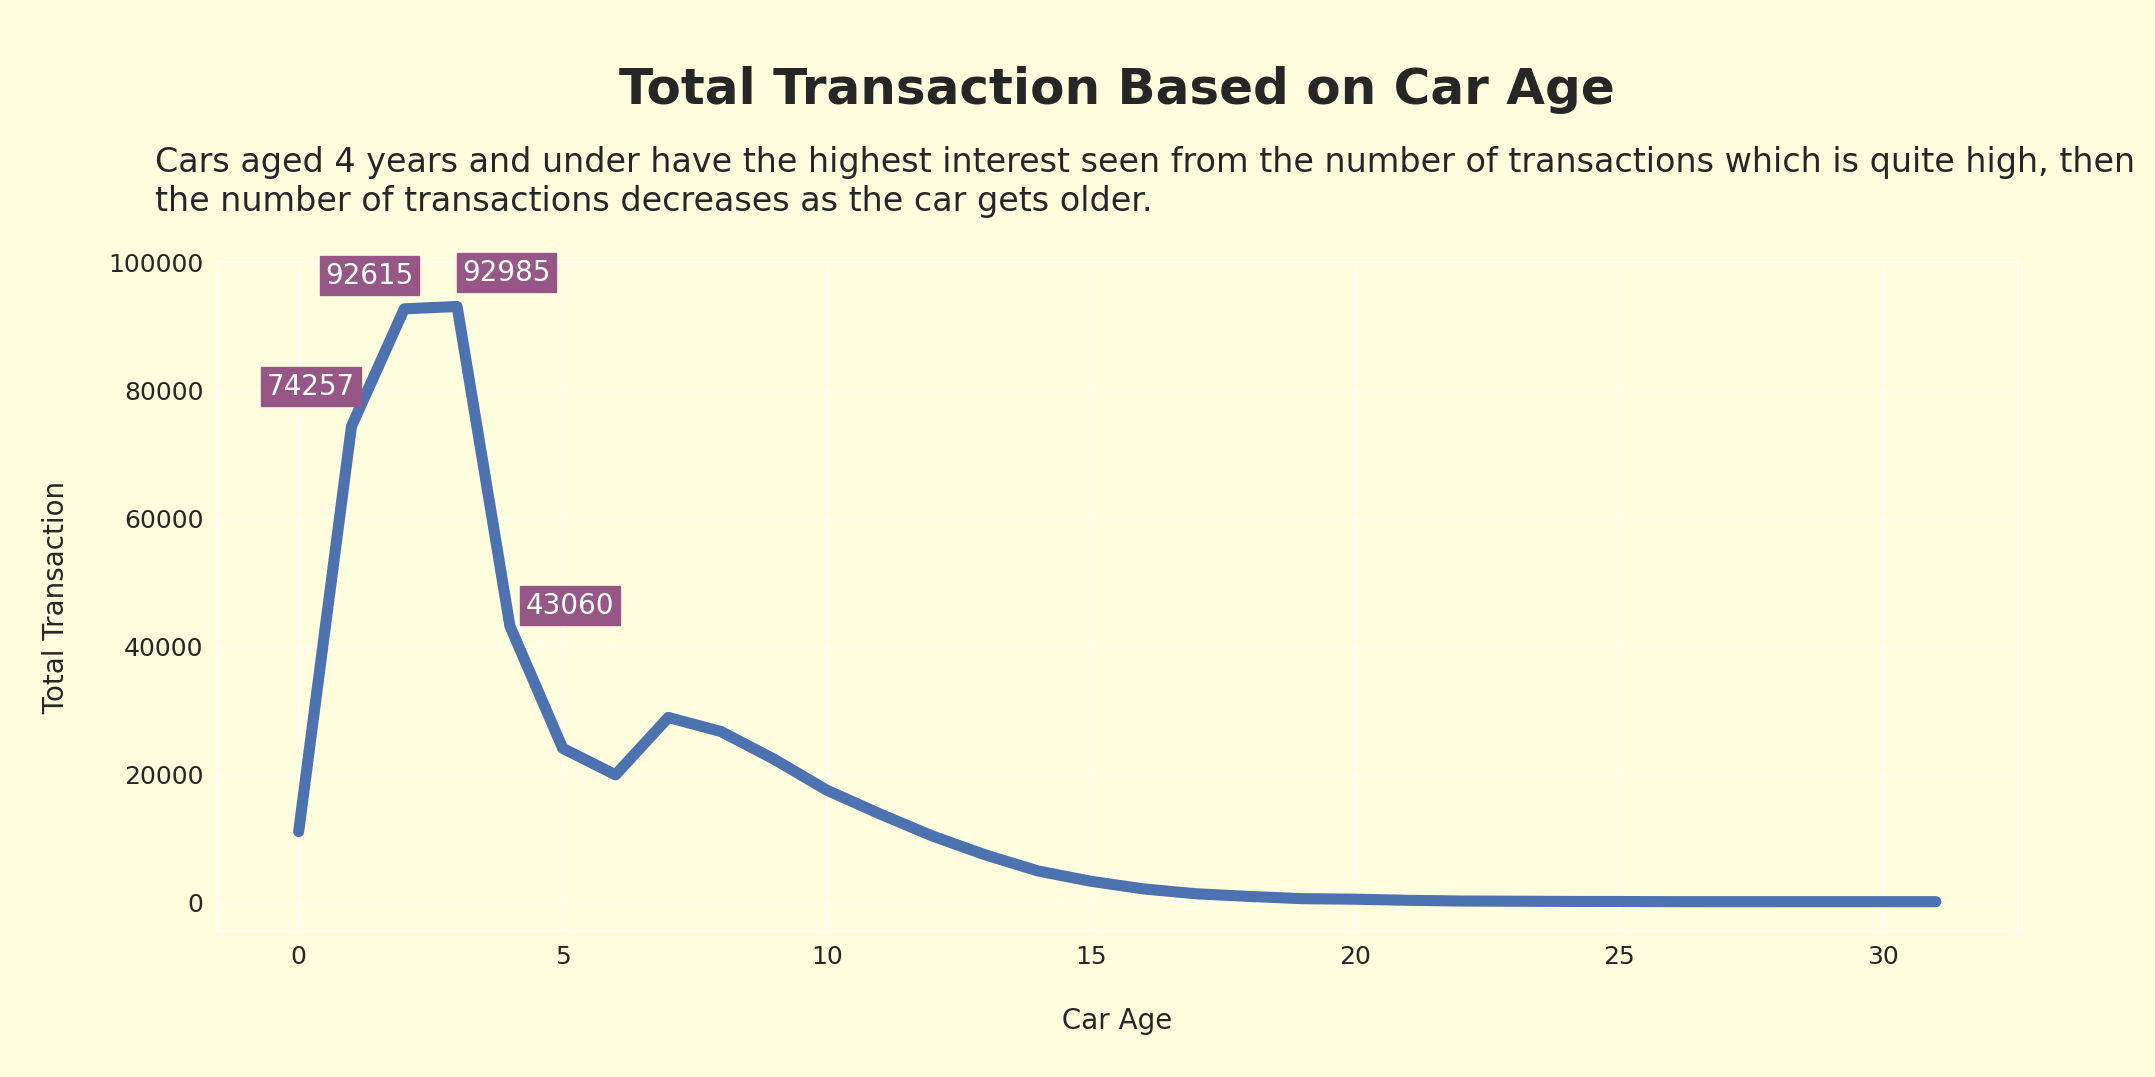

In [64]:
# set background color
sns.set(rc={'axes.facecolor':'Lightyellow', 'figure.facecolor':'Lightyellow'})

ax = sns.lineplot(transaction_year, x='car_age', y='count', linewidth = 8)
ax.axes.set_title('\nTotal Transaction Based on Car Age\n',fontsize=36, fontweight='bold', y=1.05, pad=50)
ax.figure.suptitle("Cars aged 4 years and under have the highest interest seen from the number of transactions which is quite high, then \nthe number of transactions decreases as the car gets older.\n",
                   size=24, x=0.05, y=1.02, ha='left')

# label points on the plot
#1
plt.text(x = transaction_year[transaction_year['car_age']==1]['car_age']-1.6, # x-coordinate position of data label
 y = transaction_year[transaction_year['car_age']==1]['count']+5000, # y-coordinate position of data label, adjusted to be 150 below the data point
 s = '{:.0f}'.format(transaction_year[transaction_year['car_age']==1]['count'].values[0]), # data label, formatted to ignore decimals
 color = 'white',  # set colour of line
 fontsize = 20).set_backgroundcolor('#965786')

#2
plt.text(x = transaction_year[transaction_year['car_age']==2]['car_age']-1.5, # x-coordinate position of data label
 y = transaction_year[transaction_year['car_age']==2]['count']+4000, # y-coordinate position of data label, adjusted to be 150 below the data point
 s = '{:.0f}'.format(transaction_year[transaction_year['car_age']==2]['count'].values[0]), # data label, formatted to ignore decimals
 color = 'white',  # set colour of line
 fontsize = 20).set_backgroundcolor('#965786')

#3
plt.text(x = transaction_year[transaction_year['car_age']==3]['car_age']+0.1, # x-coordinate position of data label
 y = transaction_year[transaction_year['car_age']==3]['count']+4000, # y-coordinate position of data label, adjusted to be 150 below the data point
 s = '{:.0f}'.format(transaction_year[transaction_year['car_age']==3]['count'].values[0]), # data label, formatted to ignore decimals
                 color = 'white',  # set colour of line
 fontsize = 20).set_backgroundcolor('#965786')

#4
plt.text(x = transaction_year[transaction_year['car_age']==4]['car_age']+0.3, # x-coordinate position of data label
 y = transaction_year[transaction_year['car_age']==4]['count']+2000, # y-coordinate position of data label, adjusted to be 150 below the data point
 s = '{:.0f}'.format(transaction_year[transaction_year['car_age']==4]['count'].values[0]), # data label, formatted to ignore decimals
 color = 'white',  # set colour of line
 fontsize = 20).set_backgroundcolor('#965786')

plt.xlabel('\n Car Age \n', fontsize=20)
plt.ylabel('\n Total Transaction \n', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yticks(rotation=0)
plt.ylim(top=100000)
plt.show()

From a demand perspective, it can be seen that buyers are more likely to buy cars aged 4 years and under, while from a supply perspective, a slight conclusion can be drawn that vehicle owners tend to auction their vehicles despite their age.

The graph above shows an unstable transaction history, and because the data is the result of scrapping from various resources, the monthly transaction history data created cannot be used as a benchmark.

Cars aged 4 years and under have the highest interest as seen from the number of transactions which is quite high and then the number of transactions decreases as the age of the car increases.

### C. Based on Brand

#### I. Best Selling Brand

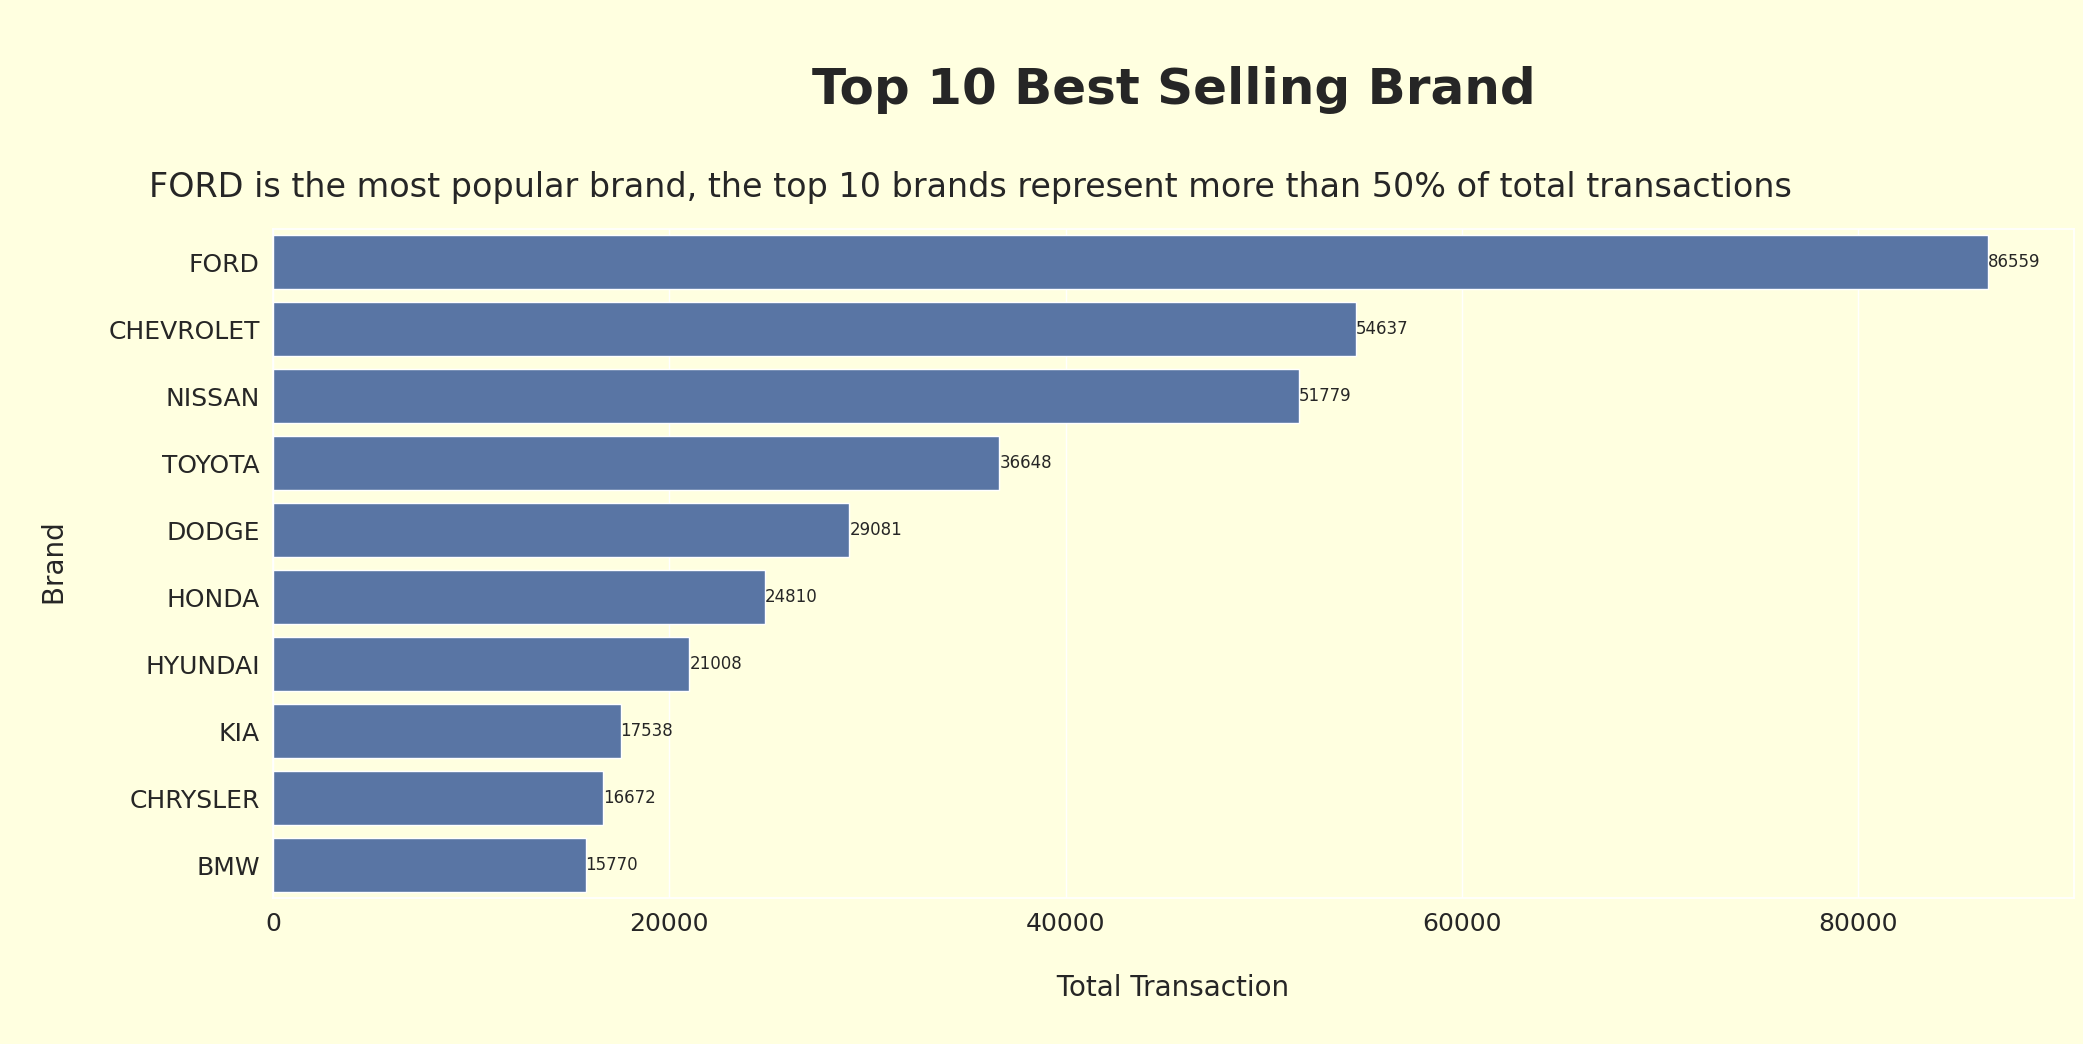

In [65]:
sns.set(rc={'axes.facecolor':'Lightyellow', 'figure.facecolor':'Lightyellow'})

ax = sns.countplot(y=df_clean.brand, order=df_clean.brand.value_counts().iloc[:10].index)

ax.axes.set_title('\nTop 10 Best Selling Brand\n',fontsize=36, fontweight='bold', y=1, pad=50)
ax.figure.suptitle("FORD is the most popular brand, the top 10 brands represent more than 50% of total transactions", size=24, x=.02, y=.95, ha='left')
ax.bar_label(ax.containers[0])

plt.xlabel('\n Total Transaction \n', fontsize=20)
plt.ylabel('\n Brand \n', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yticks(rotation=0)
plt.show()

FORD is the most popular car, if the transactions of the 10 brands with the highest sales are added up they can represent more than 50% of total transactions

#### II. Top 3 Monthly Sales by Brand

In [66]:
top_brand_sale = df_clean.groupby(['month_year', 'brand'], as_index=False)['vin'].count().rename({'vin' : 'count'}, axis=1).sort_values(['month_year','count'], ascending=[False, False])
top_brand_sale = top_brand_sale.sort_values(['month_year', 'count'], ascending=[True, False]).groupby('month_year').head(3)
top_brand_sale = top_brand_sale.sort_values(by=['month_year'], key=lambda x: x.map(custom_dict))

In [67]:
fig = go.Figure()

for i in range(0,3):
    fig.add_trace(go.Scatter(
        x=top_brand_sale[top_brand_sale.brand == top_brand_sale.brand.unique()[i]].month_year,
        y=top_brand_sale[top_brand_sale.brand == top_brand_sale.brand.unique()[i]]['count'],
        name=(top_brand_sale.brand.unique()[i])
    ))



annotations = []

annotations.append(dict(xref='paper', yref='paper', x=0.25, y=1.3,
                              xanchor='left', yanchor='bottom',
                              text='<br><b> Monthly Top 3 Sales by Brand <b>',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))

annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.1,
                              xanchor='left', yanchor='bottom',
                              text='FORD is the brand with the most sales every month, while CHEVROLET and NISSAN take turns <br>filling second place.',
                              font=dict(family='Arial',
                                        size=18,
                                        color='rgb(37,37,37)'),
                              showarrow=False))

fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    margin=dict(
        l=80,
        r=80,
        b=50,
        t=150,
        pad=10
    ),
    paper_bgcolor="LightYellow",
    plot_bgcolor="rgb(255, 249, 204)",
    annotations=annotations
)

# Set axis title
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Total Transaction")

fig.show()

#### D. Based on Body Type

In [68]:
fig = px.histogram(df_clean, y='body_simple',
                   color='body_simple',
                   labels={'body_simple': 'Body'},
                   title='<b> Best Selling Body Type <b>',
                   width=1000,
                   height=450
                  )

# Sorting y
fig.update_yaxes(categoryorder='total ascending')

fig.update_layout(paper_bgcolor='LightYellow',
                  plot_bgcolor="LightYellow",
                  xaxis_title='Total Transaction',
                  yaxis_title="Brand",
                  title=dict(font=dict(size=30), automargin=True, x=0.5, y=.95),
                  margin=dict(
                      l=100,
                      r=80,
                      b=50,
                      t=150,
                      pad=10
                     ))


fig.add_annotation(xref='paper', yref='paper', x=0, y=1.35,
                              text='<br>Sedans and SUVs are far superior in terms of sales. This is also due to the increasing number of brands <br>using these two body types as the basis for the cars they make because of their popularity.',
                              font=dict(family='Arial',
                                        size=16),
                              showarrow=False)

fig.show()

Output hidden; open in https://colab.research.google.com to view.

To prove that many brands make models based on sedan and SUV, the grouping will be carried out on the dataset



In [69]:
df_clean.groupby(['brand', 'body_simple'], as_index=False)['model'].nunique().sort_values('model', ascending=False).head(20)

,brand,body_simple,model
32,CHEVROLET,Sedan,35
59,FORD,Sedan,29
107,LEXUS,Sedan,21
27,CHEVROLET,CAB,18
47,DODGE,Sedan,17
129,MERCEDES-BENZ,Sedan,16
86,INFINITI,Sedan,15
122,MAZDA,Sedan,14
15,BMW,Sedan,14
39,CHRYSLER,Sedan,14


In [70]:
df_clean.head(2)

,vin,year,brand,body_simple,model,trim,made_in,transmission,condition,color,interior,car_age,odometer,state,seller,sellingprice,mmr,is_sold_below_mmr,day_of_week,is_weekend,hour_only,month_year,sale_date,sale_year,latitude,longitude
0,wba3c1c51ek116351,2014,BMW,Sedan,3 Series,328I SULEV,DEU,Automatic,4.5,Gray,Black,1,1331.0,CA,Financial Services Remarketing (Lease),30000,31900,1,Thu,0,4,Jan-15,2015-01-15,2015,37.271875,-119.270415
1,yv1612tb4f1310987,2015,VOLVO,Sedan,S60,T5,SWE,Automatic,4.1,White,Black,0,14282.0,CA,Volvo Na Rep/World Omni,27750,27500,0,Thu,0,4,Jan-15,2015-01-29,2015,37.271875,-119.270415


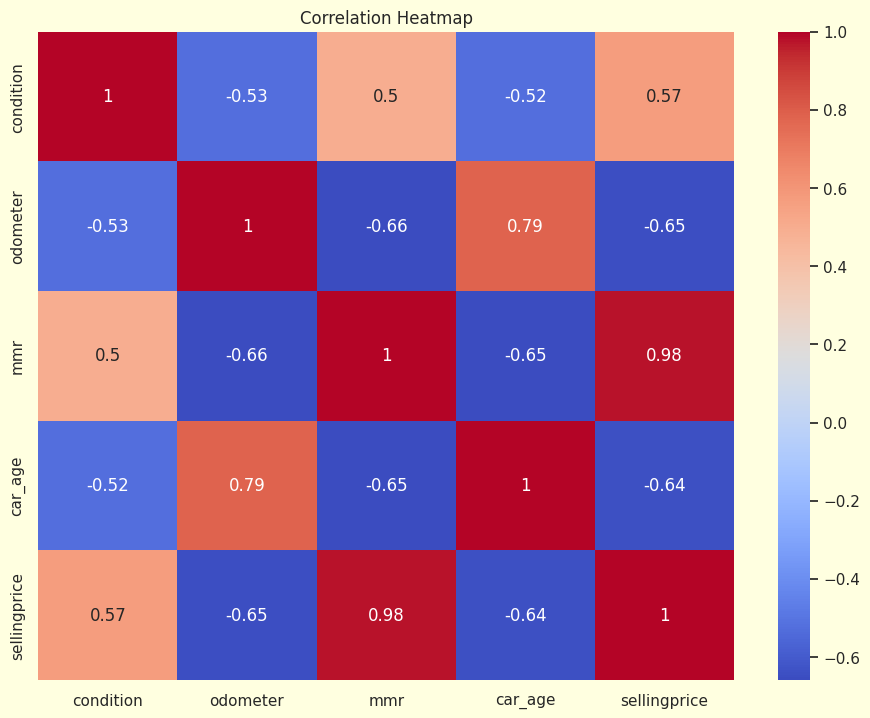

In [71]:
# based on numerical values
# Distribution of Numerical Features
numerical_columns = ['condition', 'odometer', 'mmr', 'car_age', 'sellingprice']
# Correlation Analysis
correlation_matrix = df_clean[numerical_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Looking at the above numerical features analysis, we see that car_age, odometer, and of course mmr are strong features to predict selling price. So we'll continue with them in our models.

#### E. Based on States

In [72]:
state_sales = df_clean.groupby(['state', 'latitude', 'longitude'], as_index=False)['vin'].count().rename({'vin':'count'}, axis=1)

In [73]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scattergeo(
        lon = state_sales['longitude'],
        lat = state_sales['latitude'],
        text = state_sales['state'],
        mode = 'markers',
        marker = dict(
            size = 15,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'speed',
            cmin = 0,
            color = state_sales['count'],
            cmax = state_sales['count'].max(),
            colorbar_title="Total Transaction"
        )))

fig.update_geos(
    visible=False, resolution=50, scope="north america",
    showcountries=True, countrycolor="Black",
    showsubunits=True, subunitcolor="Blue"
)

annotations = []

annotations.append(dict(xref='paper', yref='paper', x=0.05, y=1.15,
                              xanchor='left', yanchor='bottom',
                              text="<br><b> Total Car Sold based on Where's the Car Come From <b>",
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))

annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Most of the cars being auctioned come from California and Florida',
                              font=dict(family='Arial',
                                        size=18,
                                        color='rgb(37,37,37)'),
                              showarrow=False))

fig.update_layout(
    autosize=False,
    width=1000,
    height=700,
    margin=dict(
        l=80,
        r=80,
        b=50,
        t=150,
        pad=10
    ),
    paper_bgcolor="LightYellow",
    annotations=annotations
)
fig.show()

### 5.3. Models with a fairly high percentage of sales below MMR

In [74]:
# Grouping model
model_mmr = df_clean.groupby(['model', 'brand', 'is_sold_below_mmr']).agg({'vin' : 'count'}).rename({'vin' : 'total_sold'}, axis=1)
model_mmr['percentage'] = round((model_mmr/(model_mmr.groupby(level=0).sum())*100), 2)
model_mmr.reset_index(inplace=True)

In [75]:
model_mmr['total_sold'].describe()

count    1509.000000
mean      329.618953
std       831.539694
min         1.000000
25%         9.000000
50%        48.000000
75%       222.000000
max      9793.000000
Name: total_sold, dtype: float64


The statistical results above will be used to determine criteria for categorizing which car models have the greatest potential to have a detrimental impact on income. Some of the criteria that will be used:

Percentage below MMR >= 50% and Total unit sold below MMR >= 48 (median)
Percentage below MMR >= 75% and Total unit sold below MMR >= 24 (half of the median)

In [76]:
# Filtering based on the given criteria
unrecomended_model = model_mmr[((model_mmr['is_sold_below_mmr']==1) & (model_mmr['percentage']> 50) & (model_mmr['total_sold']>=48)) |
                               ((model_mmr['is_sold_below_mmr']==1) & (model_mmr['percentage']> 75) & (model_mmr['total_sold']>=24))].sort_values('total_sold', ascending=False)
unrecomended_model.reset_index(drop='index', inplace=True)
unrecomended_model.head(5)

,model,brand,is_sold_below_mmr,total_sold,percentage
0,Altima,NISSAN,1,9793,52.02
1,Fusion,FORD,1,6742,53.10
2,F-150,FORD,1,6503,52.34
3,Camry,TOYOTA,1,6313,53.72
4,Escape,FORD,1,5933,51.51


In [77]:
print(f'\nTotal Model with a fairly high percentage of sales below MMR: {unrecomended_model.model.nunique()}\n\n')


Total Model with a fairly high percentage of sales below MMR: 245




The following is a list of car models and brands with a fairly high percentage of sales below MMR:

In [78]:
unrecomended_model[['brand', 'model']].sort_values(['brand', 'model']).reset_index(drop='index')
unrecomended_model.groupby('brand', as_index=False).model.count().rename(({'model':'total_model'}), axis=1).sort_values('total_model', ascending=False).head(5)

,brand,total_model
7,FORD,28
4,CHEVROLET,27
16,LEXUS,14
6,DODGE,13
33,TOYOTA,11


There are around 245 models that have a fairly high percentage of sales below MMR with Ford and Chevrolet being the largest contributors. These findings can provide information that although these two car brands can be said to have the most interest, it does not rule out the possibility that some of their models are less attractive to customers, resulting in their prices at auction not being too high.



### 5.4. Seller

In [79]:
seller_summary = df_clean.groupby(['seller'], as_index=False)[['brand', 'state', 'made_in', 'vin']].nunique().sort_values('vin', ascending=False)
seller_summary

,seller,brand,state,made_in,vin
7841,Nissan-Infiniti Lt,2,15,1,19666
4434,"Ford Motor Credit Company,Llc",28,20,5,18701
10831,The Hertz Corporation,34,31,8,17903
9938,Santander Consumer,40,18,8,14843
1283,Avis Corporation,27,26,7,12035
...,...,...,...,...,...
8334,Palm Chrysler Jeep Dodge,1,1,1,1
3417,Diamond Buick Gmc Alexandria,1,1,1,1
8330,Palm Canyon Motors,1,1,1,1
3427,Dick Brantmeier Ford Inc,1,1,1,1


## 5.5 Brands
Distribution of cars per brands

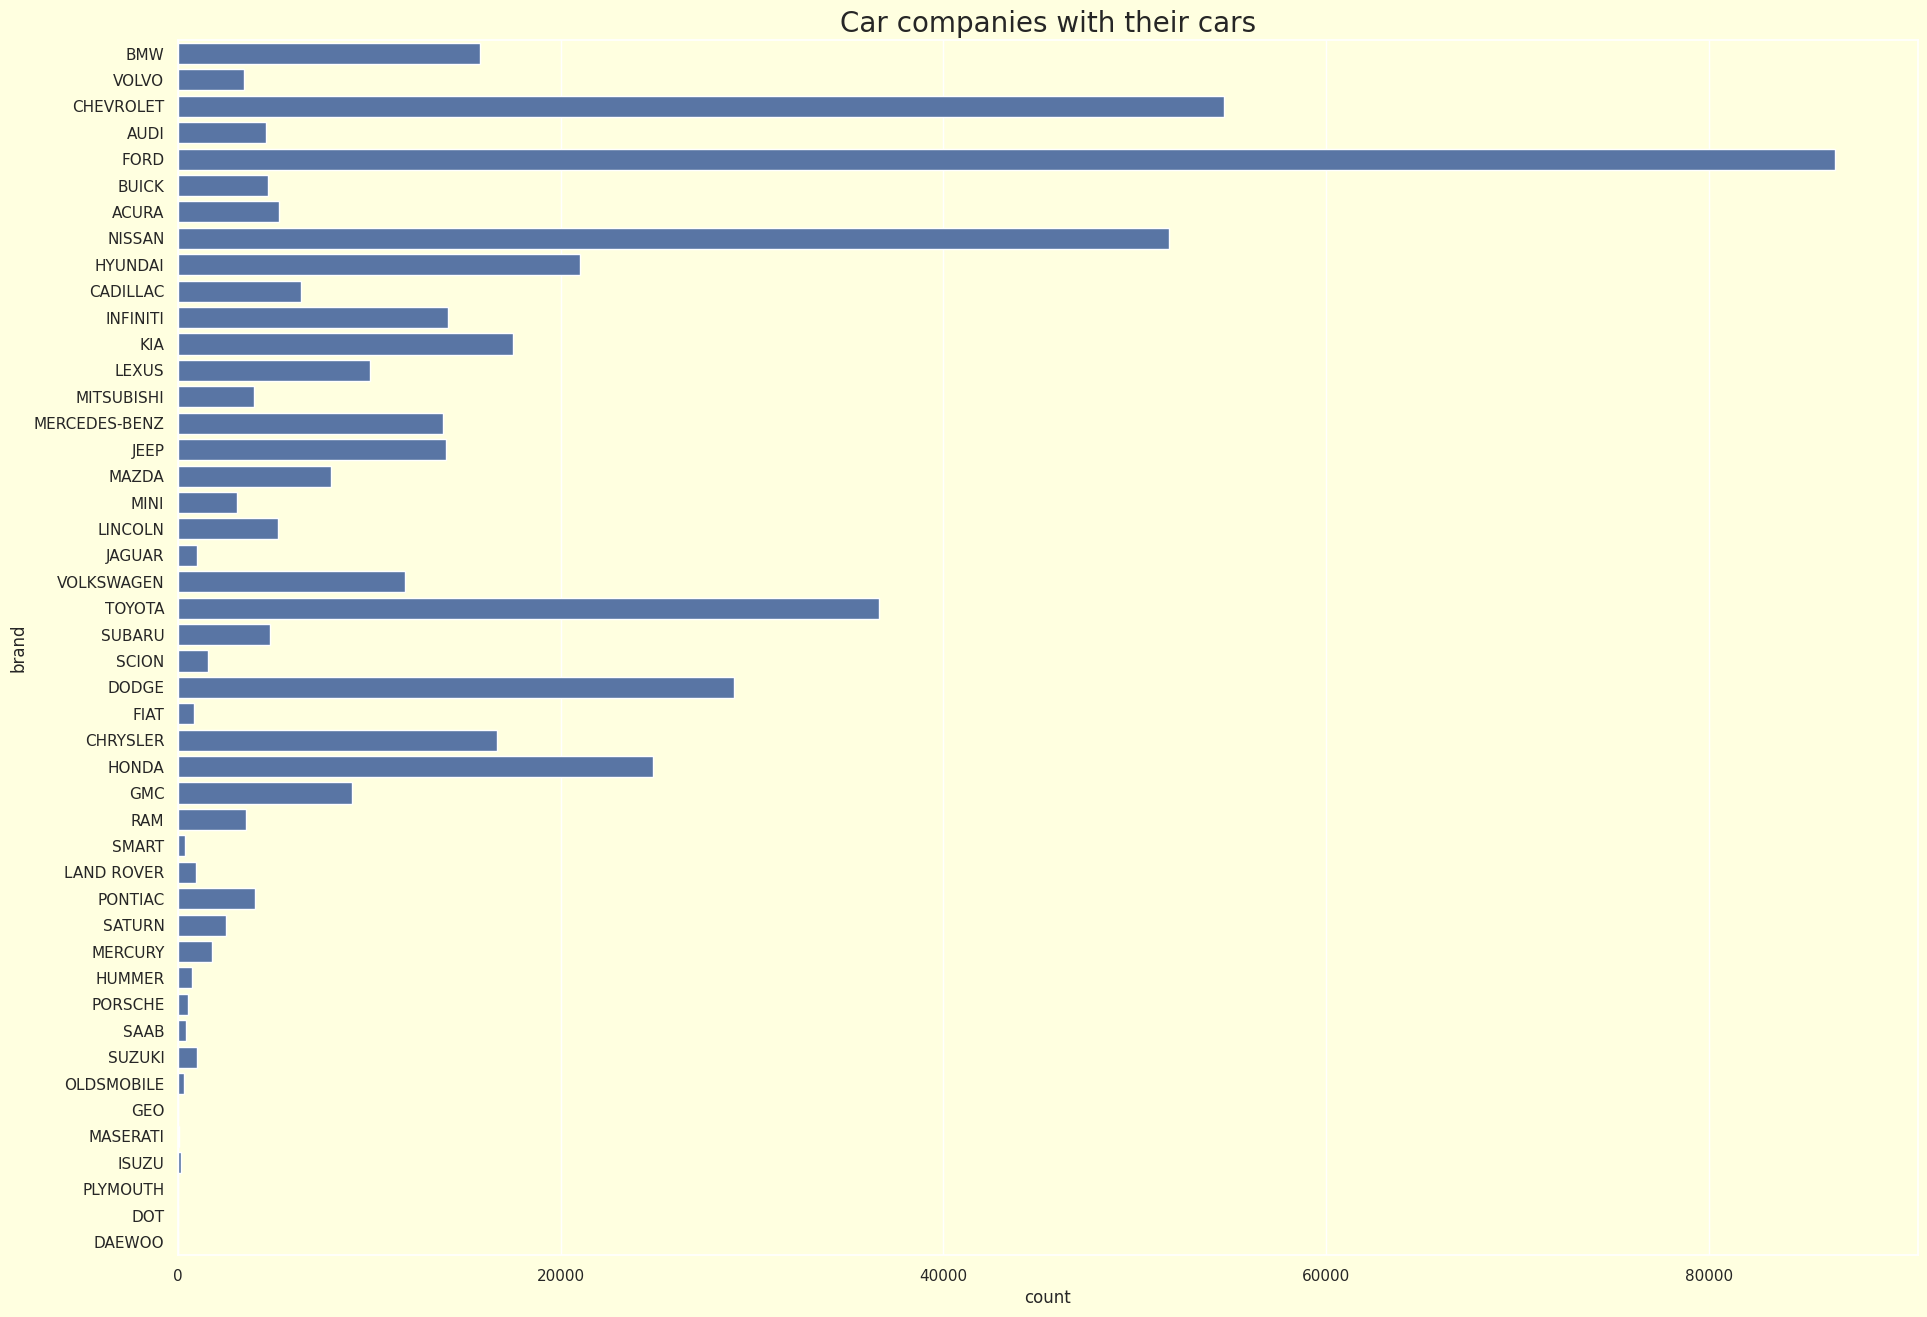

In [80]:
plt.figure(figsize = (20, 15))
sns.countplot(y = df_clean.brand)
plt.title("Car companies with their cars", fontsize = 20)
plt.show()

## 6. CONCLUSION

- Only about 48% of all cars at auction sell at or above the MMR price, and the older the year of production, the more likely a car is to sell below the MMR.

- Based on the history of monthly transactions, unstable results are recorded, and most transactions tend to occur on weekdays early in the morning, this is probably because many sellers are companies that close on weekends. And online auction closings are quite often done at midnight or early in the morning.

- Sedan and Convertible are the two most popular body types, and Ford, Chevrolet and Nissan are the most popular brands.

- There are around 245 models that have a fairly high percentage of sales below MMR with Ford and Chevrolet being the largest contributors.

- Quite a lot of sellers are creditor and banking companies, some companies have branches in several areas.

In [81]:
df_clean.head(2)

,vin,year,brand,body_simple,model,trim,made_in,transmission,condition,color,interior,car_age,odometer,state,seller,sellingprice,mmr,is_sold_below_mmr,day_of_week,is_weekend,hour_only,month_year,sale_date,sale_year,latitude,longitude
0,wba3c1c51ek116351,2014,BMW,Sedan,3 Series,328I SULEV,DEU,Automatic,4.5,Gray,Black,1,1331.0,CA,Financial Services Remarketing (Lease),30000,31900,1,Thu,0,4,Jan-15,2015-01-15,2015,37.271875,-119.270415
1,yv1612tb4f1310987,2015,VOLVO,Sedan,S60,T5,SWE,Automatic,4.1,White,Black,0,14282.0,CA,Volvo Na Rep/World Omni,27750,27500,0,Thu,0,4,Jan-15,2015-01-29,2015,37.271875,-119.270415


In [82]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

In [83]:
# Encoding categorical variables

categorical_features = ['brand', 'body_simple', 'model', 'trim', 'made_in', 'transmission', 'color', 'state', 'seller', 'day_of_week']
label_encoder = LabelEncoder()
for column in categorical_features:
    df_clean[column] = label_encoder.fit_transform(df_clean[column])

numerical_features = ['condition', 'odometer', 'mmr', 'car_age']

# Feature scaling
scaler = StandardScaler()
df_clean[numerical_features] = scaler.fit_transform(df_clean[numerical_features])

## Model Training and Evaluation

### Linear Regression

In [84]:
# Splitting the dataset
X = df_clean.drop(['sellingprice', 'year', 'brand', 'trim', 'vin', 'state', 'interior', 'seller', 'body_simple', 'latitude', 'longitude', 'brand', 'made_in', 'day_of_week',	'is_weekend',	'hour_only',	'month_year',	'sale_date',	'sale_year'], axis=1)  # Include the engineered features and CarName
y = df_clean['sellingprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2_square = r2_score(y_test,y_pred)
print(f" R-squared: {r2_square}")
print(f'Mean Squared Error: {mse}')

 R-squared: 0.9764869055363016
Mean Squared Error: 1289727.4259324127


In [85]:
import statsmodels.api as sm
# Add a constant term for the intercept
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Fit the model using statsmodels
model_sm = sm.OLS(y_train, X_train_sm).fit()

# Print the summary
print(model_sm.summary())

# Predict using statsmodels model
y_pred_sm = model_sm.predict(X_test_sm)

# Calculate metrics using statsmodels predictions
mse_sm = mean_squared_error(y_test, y_pred_sm)
r2_square_sm = r2_score(y_test, y_pred_sm)
print(f"R-squared (statsmodels): {r2_square_sm}")
print(f'Mean Squared Error (statsmodels): {mse_sm}')


                            OLS Regression Results                            
Dep. Variable:           sellingprice   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                 2.059e+06
Date:                Mon, 27 May 2024   Prob (F-statistic):               0.00
Time:                        14:58:17   Log-Likelihood:            -3.3657e+06
No. Observations:              397916   AIC:                         6.732e+06
Df Residuals:                  397907   BIC:                         6.732e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.383e+04      4.78

The Mean Squared Error (MSE) might look large due to the scale of the target variable (car prices). MSE is sensitive to the scale of the data, so if the prices are in a high range (e.g., thousands of dollars), the MSE will naturally be larger. The R-squared value (0.976) indicates that your model is explaining a large proportion of the variance in the target variable, which suggests that the model is performing well despite the large MSE.

In [86]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
265187,10300,10238.870944,61.129056
171113,10200,10187.390724,12.609276
246845,2000,1197.349015,802.650985
320254,15700,16264.016730,-564.016730
252665,13000,13323.473357,-323.473357
...,...,...,...
143726,9200,10307.219027,-1107.219027
409952,3700,4333.761765,-633.761765
27505,15800,16507.427054,-707.427054
59100,10800,10534.205393,265.794607


Additionally, one might want to visualize the predictions versus the actual values to gain more insight into the model's performance:

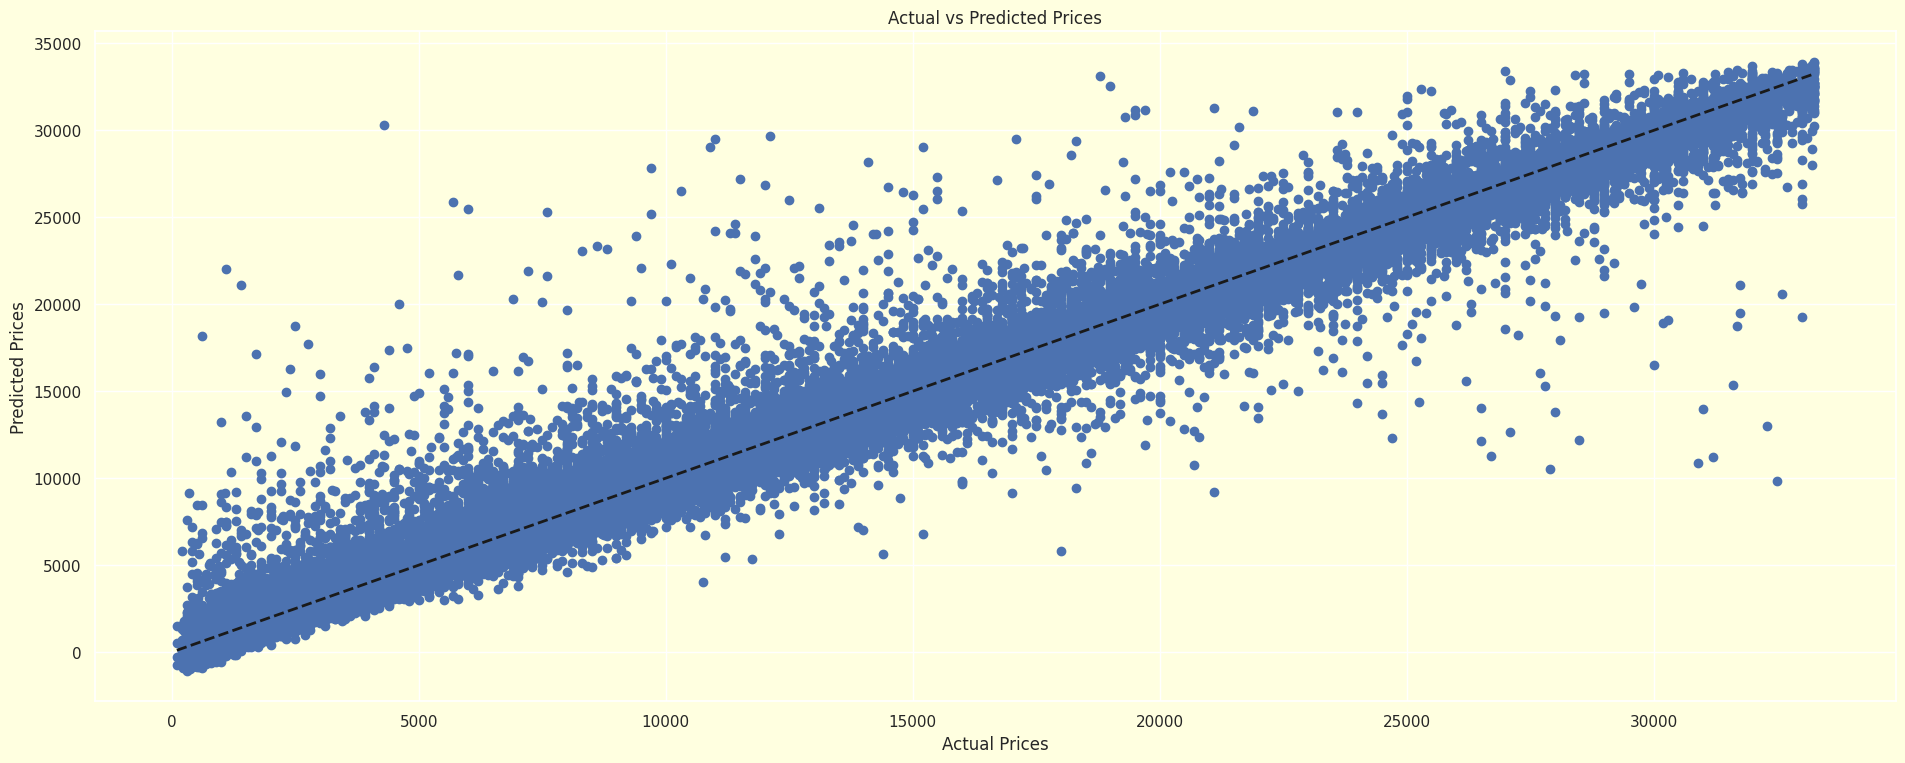

In [87]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

Since in our dataset we already have the market estimated price of the car (mmr), the model is probably using mmr as a strong feature and estimating very well depending on that. To have a real prediction without relying on mmr feature, now we will drop that and make estimations depending on other features:

In [88]:
# Linear Regression, without mmr this time
# Splitting the dataset
df_full = df_clean.copy()
X = df_clean.drop(['mmr', 'sellingprice', 'year', 'brand', 'trim', 'vin', 'state', 'interior', 'seller', 'body_simple', 'latitude', 'longitude', 'brand', 'made_in', 'day_of_week',	'is_weekend',	'hour_only',	'month_year',	'sale_date',	'sale_year', 'is_sold_below_mmr'], axis=1)  # Include the engineered features and CarName
y = df_clean['sellingprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2_square = r2_score(y_test,y_pred)
print(f" R-squared: {r2_square}")
print(f'Mean Squared Error: {mse}')

 R-squared: 0.5225467650076231
Mean Squared Error: 26189004.28952576


In [89]:
# Linear Regression, without mmr this time
# Splitting the dataset
df_test = df_clean.copy()
X = df_test.drop(['mmr', 'sellingprice', 'year', 'brand', 'trim', 'vin', 'state', 'interior', 'seller', 'body_simple', 'latitude', 'longitude', 'brand', 'made_in', 'day_of_week',	'is_weekend',	'hour_only',	'month_year',	'sale_date',	'sale_year', 'is_sold_below_mmr', 'model', 'color'], axis=1)  # Include the engineered features and CarName
y = df_test['sellingprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2_square = r2_score(y_test,y_pred)
print(f" R-squared: {r2_square}")
print(f'Mean Squared Error: {mse}')

 R-squared: 0.5209105719897242
Mean Squared Error: 26278751.85603859


In [90]:
# Assuming df_clean is your cleaned DataFrame
# Filter the dataset for only 'Ford' cars
print(df_full.head())
df_ford = df_full[df_full['brand'] == 'FORD']
print(len(df_ford))
# Drop unnecessary columns and prepare the dataset
X = df_ford.drop(['mmr', 'sellingprice', 'year', 'brand', 'trim', 'vin', 'state', 'interior', 'seller', 'body_simple', 'latitude', 'longitude', 'made_in', 'day_of_week', 'is_weekend', 'hour_only', 'month_year', 'sale_date', 'sale_year', 'is_sold_below_mmr', 'model', 'color'], axis=1)
y = df_ford['sellingprice']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training with scikit-learn
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2_square = r2_score(y_test, y_pred)
print(f"R-squared: {r2_square}")
print(f'Mean Squared Error: {mse}')

# Fit the model using statsmodels for detailed summary
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

model_sm = sm.OLS(y_train, X_train_sm).fit()

# Print the summary
print(model_sm.summary())

# Predict using statsmodels model
y_pred_sm = model_sm.predict(X_test_sm)

# Calculate metrics using statsmodels predictions
mse_sm = mean_squared_error(y_test, y_pred_sm)
r2_square_sm = r2_score(y_test, y_pred_sm)
print(f"R-squared (statsmodels): {r2_square_sm}")
print(f'Mean Squared Error (statsmodels): {mse_sm}')

                 vin  year  brand  body_simple  model  trim  made_in  \
0  wba3c1c51ek116351  2014      2            5      8   275        1   
1  yv1612tb4f1310987  2015     45            5    592  1463        6   
2  1g1pc5sb2e7128460  2014      5            5    185    57        7   
3  wauffafl3en030343  2014      1            5     51    84        1   
4  2g1fb3d37e9218789  2014      5            1    129  1042        7   

   transmission  condition  color interior   car_age  odometer  state  seller  \
0             0   1.150484      7    Black -0.984620 -1.382674      3    4177   
1             0   0.721750     17    Black -1.253682 -1.098620      3   11708   
2             0  -1.529104      1    Black -1.253682 -0.784211      3    3877   
3             0   0.828933     17    Black -1.253682 -1.202253      3     785   
4             0  -0.457269     14    Black -0.984620 -1.306391      3    3178   

   sellingprice       mmr  is_sold_below_mmr  day_of_week  is_weekend  \
0      

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
import statsmodels.api as sm
# Add a constant term for the intercept
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Fit the model using statsmodels
model_sm = sm.OLS(y_train, X_train_sm).fit()

# Print the summary
print(model_sm.summary())

# Predict using statsmodels model
y_pred_sm = model_sm.predict(X_test_sm)

# Calculate metrics using statsmodels predictions
mse_sm = mean_squared_error(y_test, y_pred_sm)
r2_square_sm = r2_score(y_test, y_pred_sm)
print(f"R-squared (statsmodels): {r2_square_sm}")
print(f'Mean Squared Error (statsmodels): {mse_sm}')

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Fit a linear regression model with polynomial features
poly_model = LinearRegression()
poly_model.fit(X_poly, y)

# Evaluate the model
y_poly_pred = poly_model.predict(poly.fit_transform(X_test))
mse_poly = mean_squared_error(y_test, y_poly_pred)
r2_poly = r2_score(y_test, y_poly_pred)
print(f"R-squared (Polynomial Regression): {r2_poly}")
print(f'Mean Squared Error (Polynomial Regression): {mse_poly}')


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming X_train_sm includes the constant term
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_sm.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]

print(vif_data)


In [ ]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

### Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Train a decision tree regressor
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_model.predict(X_test)

# Evaluate the model
mse_dt = mean_squared_error(y_test, y_pred_dt)
print(f'Decision Tree Mean Squared Error: {mse_dt}')

### Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Train a random forest regressor
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Random Forest Mean Squared Error: {mse_rf}')

### Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Train a gradient boosting regressor
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_model.predict(X_test)

# Evaluate the model
mse_gb = mean_squared_error(y_test, y_pred_gb)
print(f'Gradient Boosting Mean Squared Error: {mse_gb}')

### XGBoost

In [ ]:
import xgboost as xgb

# Train an XGBoost regressor
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f'XGBoost Mean Squared Error: {mse_xgb}')

### Neural Network (MLPRegressor)

In [ ]:
from sklearn.neural_network import MLPRegressor

# Train a neural network regressor
mlp_model = MLPRegressor()
mlp_model.fit(X_train, y_train)

# Make predictions
y_pred_mlp = mlp_model.predict(X_test)

# Evaluate the model
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
print(f'Neural Network Mean Squared Error: {mse_mlp}')

### K-Nearest Neighbors Regressor

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Train a K-Nearest Neighbors regressor
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn_model.predict(X_test)

# Evaluate the model
mse_knn = mean_squared_error(y_test, y_pred_knn)
print(f'K-Nearest Neighbors Mean Squared Error: {mse_knn}')

### Support Vector Regressor

In [ ]:
from sklearn.svm import SVR

# Train a support vector regressor
svr_model = SVR()
svr_model.fit(X_train, y_train)

# Make predictions
y_pred_svr = svr_model.predict(X_test)

# Evaluate the model
mse_svr = mean_squared_error(y_test, y_pred_svr)
print(f'Support Vector Regressor Mean Squared Error: {mse_svr}')

### Train and Evaluate Multiple Models

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': xgb.XGBRegressor()
}

# Train and evaluate models
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    cv_scores = cross_val_score(model, X, y, cv=5)
    cv_mean = cv_scores.mean()

    results[name] = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R-squared': r2,
        'CV Score': cv_mean
    }

# Display results
results_df = pd.DataFrame(results).T
print(results_df)

### Choosing the Best Model

After evaluating all models, you can choose the best model based on the evaluation metrics. Typically, you might look for the model with the highest R-squared value or the lowest MSE, MAE, or RMSE. Cross-validation scores also provide a good indication of model performance.

In [ ]:
best_model_name = results_df['R-squared'].idxmax()
best_model = models[best_model_name]

print(f'The best model is: {best_model_name} with R-squared of {results_df.loc[best_model_name, "R-squared"]}')

### Enhancements: Hyperparameter Tuning with RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model
rf = RandomForestRegressor()

# Initialize RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the model
rf_random.fit(X_train, y_train)

# Print the best parameters
print(f'Best parameters found: {rf_random.best_params_}')

# Make predictions with the best estimator
best_rf = rf_random.best_estimator_
y_pred_rf_best = best_rf.predict(X_test)

# Evaluate the model
mse_rf_best = mean_squared_error(y_test, y_pred_rf_best)
print(f'Random Forest Best Model Mean Squared Error: {mse_rf_best}')

### Hyperparameter Tuning with GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest as an example
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f'Best parameters found: {best_params}')

### Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score

# Evaluate the model using cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Average Cross-Validation Score: {cv_scores.mean()}')

### Feature Importance with SHAP

In [ ]:
import shap

# Initialize the explainer
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

# Plot feature importance
shap.summary_plot(shap_values, X_test)